# Company Home Task - Data Analyst
## Author: Bogdan Romanov

<br>

In [1]:
# First task
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import ttest_ind


# Second task
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Miscellaneous
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


sns.set(rc={'figure.figsize':(25,9)})

The strategy for the task consists of two major stages:
1. __Data analysis__ — this is the first step, where I will explore the data and pinpoint the variables which are not accounted for in the prediction of the upfront price. For that, I will use pivot tables, visualizations, and basic statistical tests to compare samples.
2. __Data science__ — since the task is to improve the prediction in the model, I will synthesize the model based on our data and illustrate that, indeed, the variables deducted from the data analysis do decrease the prediction error. For the illustration, I will introduce two models: the baseline version with only `predicted_distance` and `predicted_duration`, and the expended model with new variables.

The second stage can be easily removed; however, I included it to back up my theoretical insights and demonstrate that we can reduce the workload for the Data Scientists in the pipeline if the Data Analysts in the team conduct at least preliminary testing. This might be valuable because not all causality patterns can be captured by the default linear model or more sophisticated alternatives.

<br>

# Step 1. Data analysis
## _Literally: time is money, as well as the connection is also money_

In [2]:
df = pd.read_csv('Test.csv - test.csv',
                 parse_dates=['calc_created']
                 )
print(df.shape)

(4943, 26)


The dataset consists of 4943 observations and 26 variables. Each observation is an __attempt__ to order a Company service within the timeframe between February 2nd, 2020, and March 8th, 2020.

Once I open the data, even the first five rows indicate that several, at least two, regions are stored in the data because there is a vivid difference between the payments: 4 units and 72 871 units. This is explained by the `eu_indicator` variable, so let me check how the main variables are distributed in the EU/non-EU split.

In [3]:
table = pd.pivot_table(df,
                       values=['metered_price', 'upfront_price', 'duration', 'predicted_duration','distance', 'predicted_distance'],
                       index='eu_indicator',
                       sort=False
                       )
table.round(2)

,metered_price,upfront_price,duration,predicted_duration,distance,predicted_distance
eu_indicator,,,,,,
1,7.64,6.44,1052.60,857.13,8923.79,7941.45
0,18111.12,16060.66,2220.98,1422.63,10846.93,9937.80


In [4]:
table = pd.pivot_table(df, values=['metered_price', 'upfront_price', 'duration', 'predicted_duration','distance', 'predicted_distance'],
                       index='eu_indicator',
                       aggfunc='median',
                       sort=False
                       )
table = table.rename(index={0:'non-EU', 1:'EU'})
table.round(2)

,metered_price,upfront_price,duration,predicted_duration,distance,predicted_distance
eu_indicator,,,,,,
EU,5.90,5.2,842.5,747.5,6423,5825.0
non-EU,12768.24,11250.0,1738.0,1282.0,8515,8302.0


(-100.0, 50000.0)

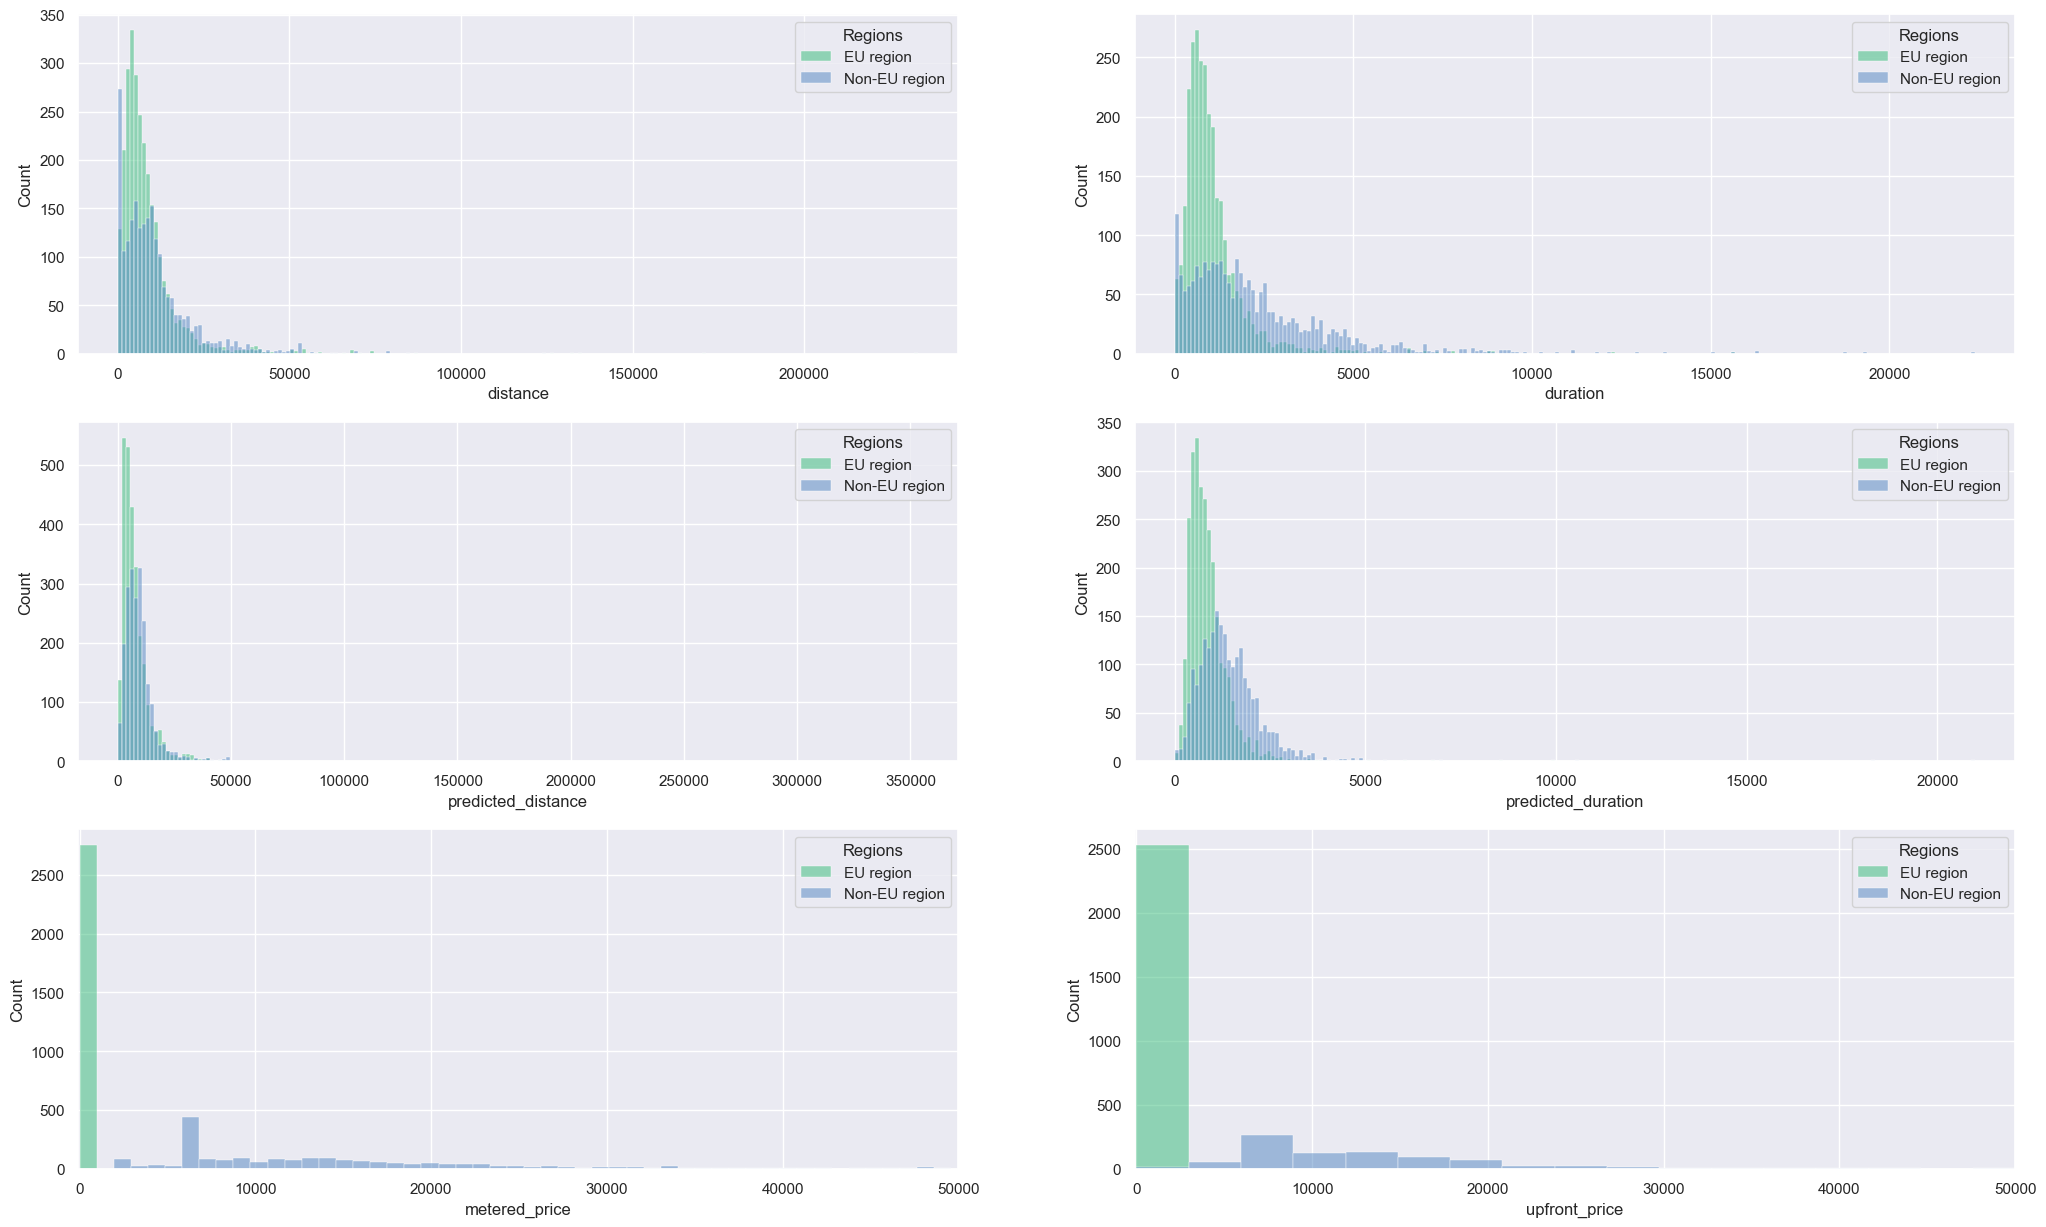

In [5]:
legend_labels = ['EU region', 'Non-EU region']


fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(25, 15))

sns.histplot(data=df,
             x='distance',
             hue='eu_indicator',
             bins=200,
             ax=axs[0,0],
             palette=['#5186C2', '#34BB78']
             ).legend(title='Regions',
                      labels=legend_labels
                      )

sns.histplot(data=df,
             x='duration',
             hue='eu_indicator',
             bins=200,
             ax=axs[0,1],
             palette=['#5186C2', '#34BB78']
             ).legend(title='Regions',
                      labels=legend_labels
                      )

sns.histplot(data=df,
             x='predicted_distance',
             hue='eu_indicator',
             bins=200,
             ax=axs[1,0],
             palette=['#5186C2', '#34BB78']
             ).legend(title='Regions',
                      labels=legend_labels
                      )

sns.histplot(data=df,
             x='predicted_duration',
             hue='eu_indicator',
             bins=200,
             ax=axs[1,1],
             palette=['#5186C2', '#34BB78']
             ).legend(title='Regions',
                      labels=legend_labels
                      )

sns.histplot(data=df,
             x='metered_price',
             hue='eu_indicator',
             bins=200,
             ax=axs[2,0],
             palette=['#5186C2', '#34BB78']
             ).legend(title='Regions',
                      labels=legend_labels
                      )

axs[2,0].set_xlim(-100, 50000)

sns.histplot(data=df,
             x='upfront_price',
             hue='eu_indicator',
             bins=200,
             ax=axs[2,1],
             palette=['#5186C2', '#34BB78']
             ).legend(title='Regions',
                      labels=legend_labels
                      )

axs[2,1].set_xlim(-100, 50000)

First of all, we see that data is not only different in its nature, but it has contrasting distributions across all variables if we introduce EU/non-EU juxtaposition.
Since the data is not normally distributed, we cannot use a parametric test for comparing samples; that is why I opt for the Wilcoxon test.

In [6]:
ttest_ind(df['duration'], df['predicted_duration'], equal_var=False, nan_policy='omit')

Ttest_indResult(statistic=17.58214043902179, pvalue=8.759452484891704e-68)

In [7]:
result_durations = wilcoxon(df['duration'], df['predicted_duration'], nan_policy='omit')
print('Wilcoxon statistic:', result_durations.statistic)
print('p-value:', result_durations.pvalue)

Wilcoxon statistic: 3339357.0
p-value: 3.8072465663156083e-162


In [8]:
result_distance = wilcoxon(df['distance'], df['predicted_distance'], nan_policy='omit')
print('Wilcoxon statistic:', result_distance.statistic)
print('p-value:', result_distance.pvalue)

Wilcoxon statistic: 4108414.0
p-value: 8.45252960532687e-57


Surprisingly, both mean and median predicted values (i.e., `predicted_distance`, `predicted_duration`, as a result, `upfront_price`) in the sample data are lower than the mean and median of the actual one. This trend is observed in both EU and non-EU regions. Moreover, this difference is statistically significant judging by the t-test result (here, I assumed that the samples are paired since they are attributed to the same service/order).

My first yet uneducated assumption would be that `predicted_distance` does not consider the time and day when the order is made; thus, it overlooks rush hours (__H1__, __H2__).
Secondly, since the orders were made from the phones, the issue with the distance could be caused by the `gps_confidence` and phone model (`device_name`) (__H3__).

I would like to keep the distinction between EU and non-EU markets because they have latent variables of income and country-region size.

In [9]:
eu_service = df[df['eu_indicator'] == 1]
noneu_service = df[df['eu_indicator'] == 0]

<br>

### Hypothesis 1

First of all, let me figure out if the time and day of order matter in the duration of a service (__H1__).

Text(0.5, 1.02, 'It is Friday and Sunday!\n Histogram for orders throughout the week in EU and non-EU regions')

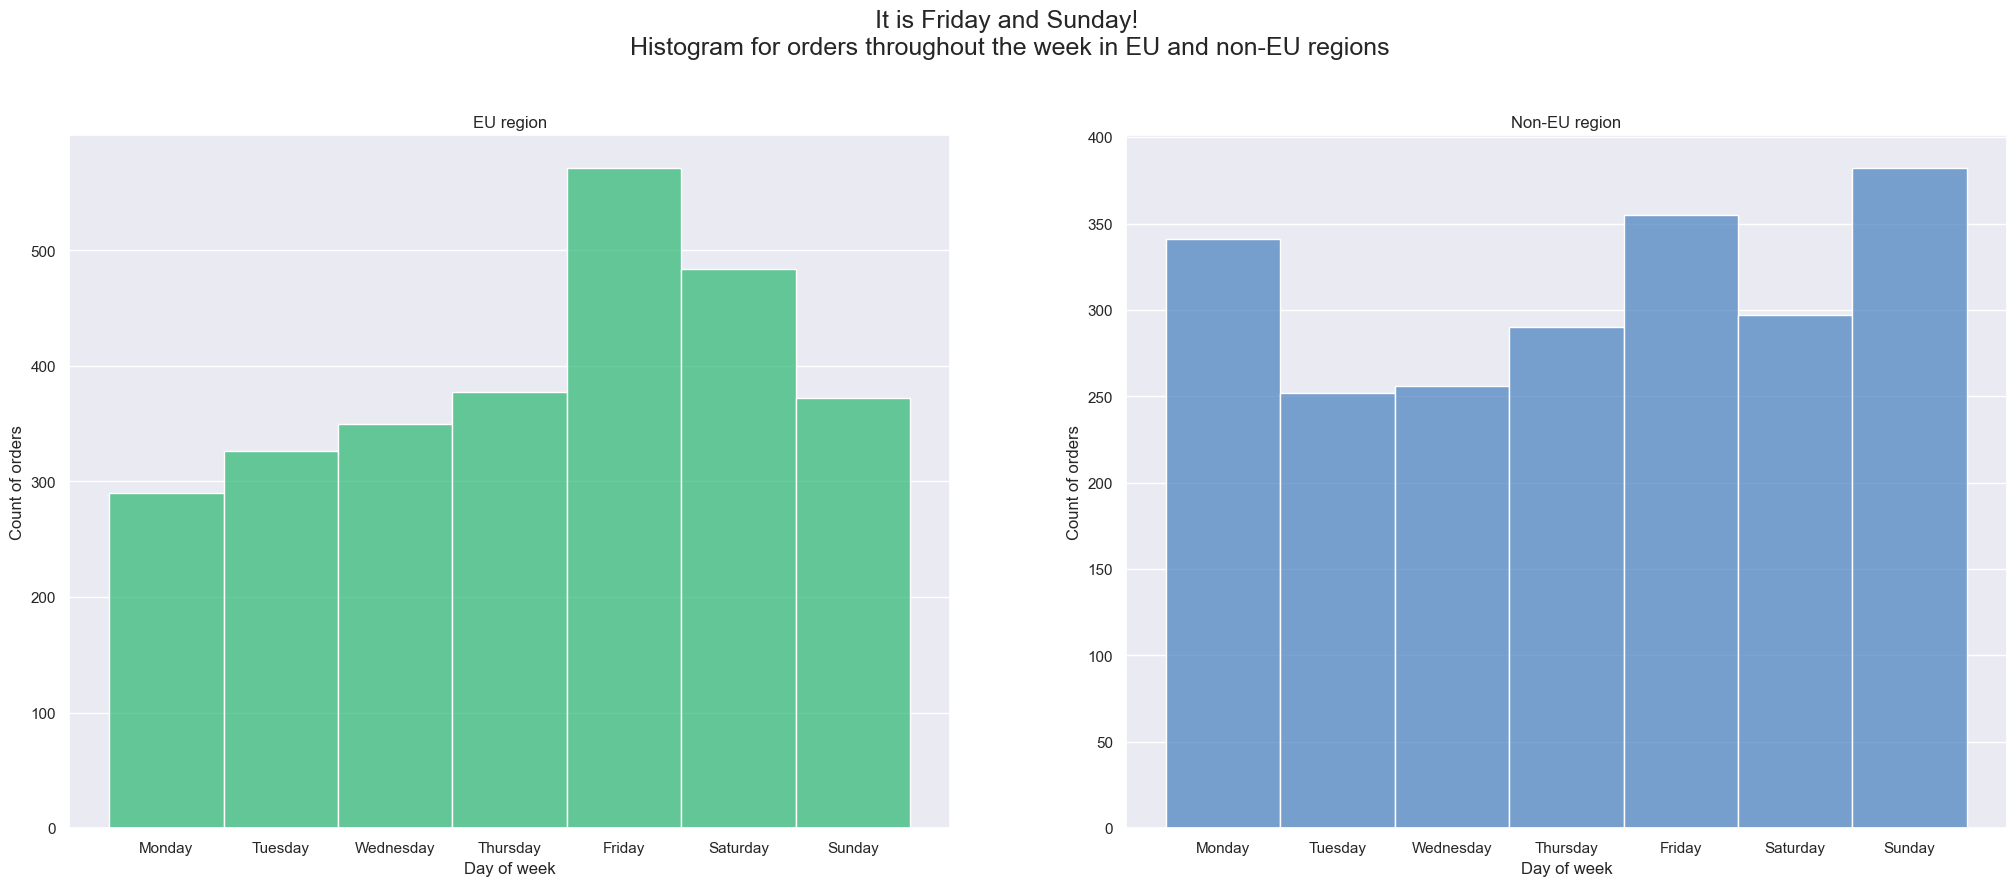

In [10]:
fig, axs = plt.subplots(ncols=2)

sns.histplot(data=eu_service,
             x=eu_service.calc_created.dt.weekday,
             bins=7,
             ax=axs[0],
             binwidth=1,
             binrange=(-0.5, 6.5),
             color='#34BB78'
             )
axs[0].set(xlabel='Day of week',
           ylabel='Count of orders',
           title='EU region'
           )
axs[0].set_xticklabels(['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axs[0].xaxis.grid(False)

sns.histplot(data=noneu_service,
             x=noneu_service.calc_created.dt.weekday,
             bins=7,
             ax=axs[1],
             binwidth=1,
             binrange=(-0.5, 6.5),
             color='#5186C2'
             )
axs[1].set(xlabel='Day of week',
           ylabel='Count of orders',
           title='Non-EU region'
           )
axs[1].set_xticklabels(['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axs[1].xaxis.grid(False)

fig.suptitle(f'It is Friday and Sunday!{os.linesep} Histogram for orders throughout the week in EU and non-EU regions', y=1.02, fontsize=18)

Even visually, it is clear that order distribution is different throughout the week, thus the surge varies as well:
- for the EU region, most orders are made on Fridays and then during the weekend;
- while for non-EU, service are made on Mondays, Fridays, and Sundays

<br>

In [11]:
EU_actual = mpatches.Patch(color='#07572F', label='Actual EU duration')
EU_predicted = mpatches.Patch(color='#68D49E', label='Predicted EU duration')
non_EU_actual = mpatches.Patch(color='#1B508C', label='Actual non-EU duration')
non_EU_predicted = mpatches.Patch(color='#BEDCFE', label='Predicted non-EU duration')

Text(0.5, 1.02, "It is Friday and Sunday!\n Overlapping barplots for service' duration throughout the week in EU and non-EU regions")

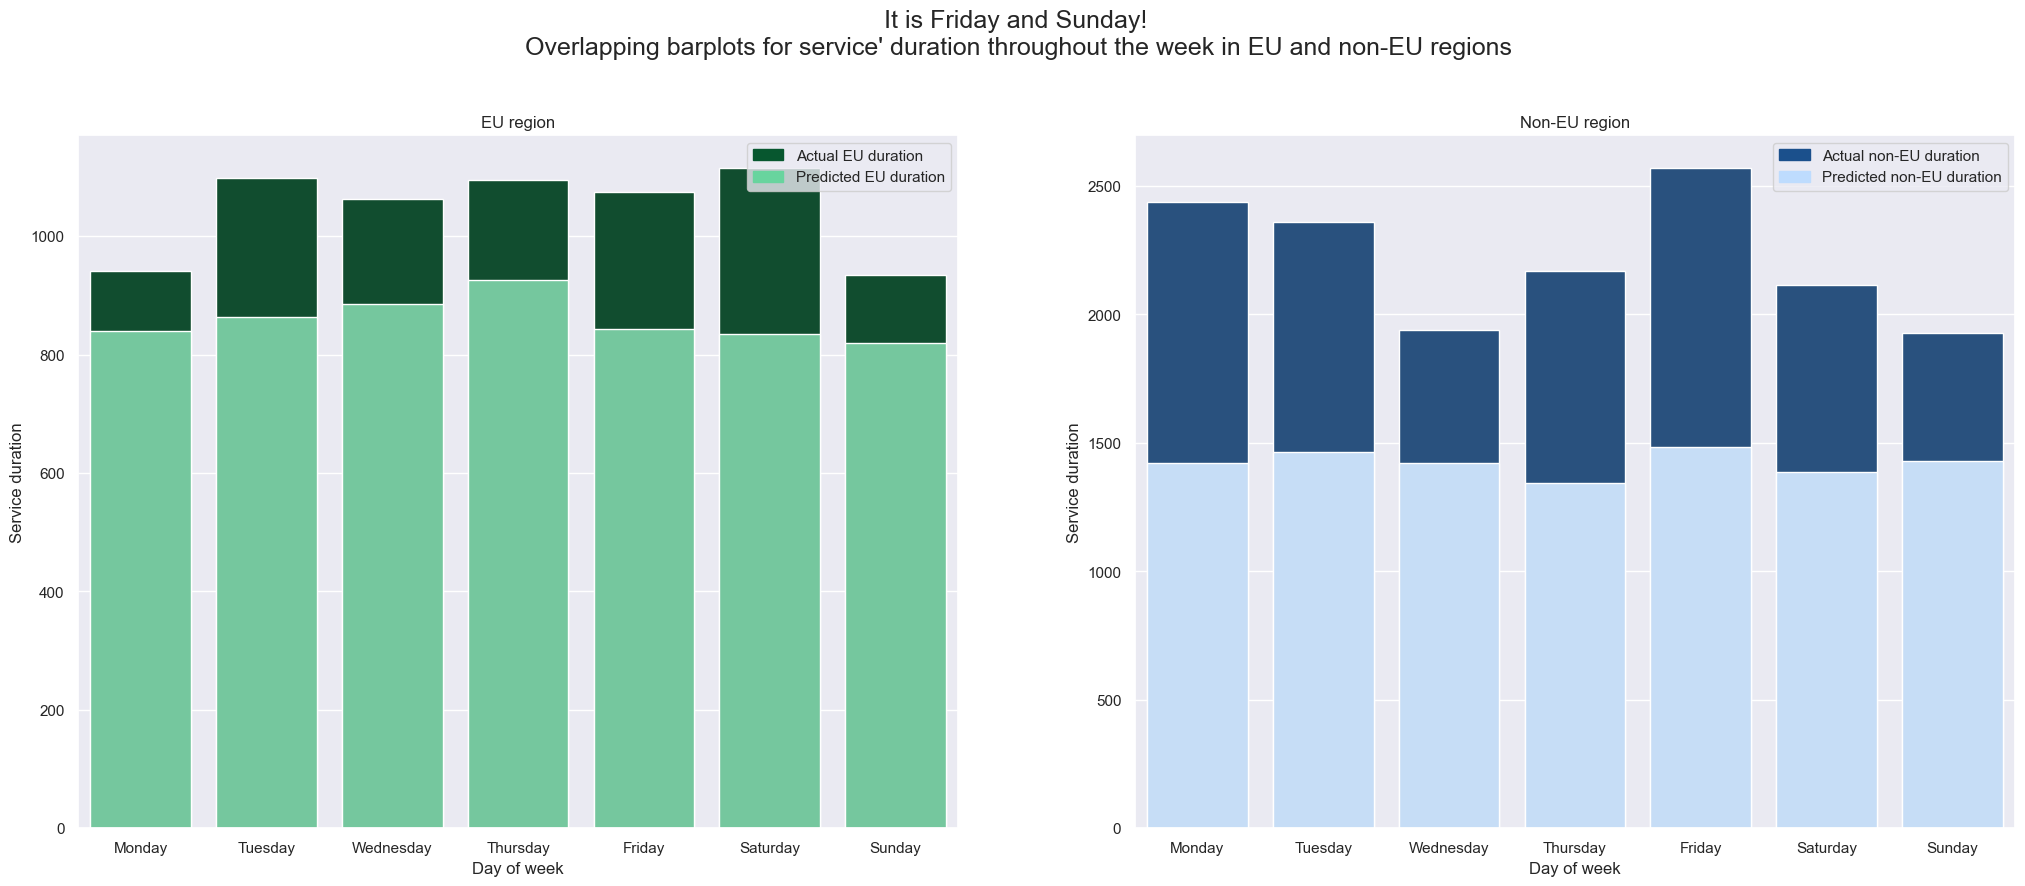

In [12]:
fig, axs = plt.subplots(ncols=2)

sns.barplot(data=eu_service,
            x=eu_service.calc_created.dt.weekday,
            y='duration',
            ax=axs[0],
            ci=False,
            color='#07572F'
            )
axs[0].set(xlabel='Day of week',
           ylabel='Service duration'
           )

sns.barplot(data=eu_service,
            x=eu_service.calc_created.dt.weekday,
            y='predicted_duration',
            ax=axs[0],
            ci=False,
            color='#68D49E'
            )
axs[0].set(xlabel='Day of week',
           ylabel='Service duration',
           title='EU region'
           )
axs[0].legend(handles=[EU_actual, EU_predicted])

sns.barplot(data=noneu_service,
            x=noneu_service.calc_created.dt.weekday,
            y='duration',
            ax=axs[1],
            ci=False,
            color='#1B508C')
axs[1].set(xlabel='Day of week',
           ylabel='Service duration'
           )

sns.barplot(data=noneu_service,
            x=noneu_service.calc_created.dt.weekday,
            y='predicted_duration',
            ax=axs[1],
            ci=False,
            color='#BEDCFE'
            )
axs[1].set(xlabel='Day of week',
           ylabel='Service duration',
           title='Non-EU region'
           )
axs[1].legend(handles=[non_EU_actual, non_EU_predicted])

axs[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axs[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

fig.suptitle(f"It is Friday and Sunday!{os.linesep} Overlapping barplots for service' duration throughout the week in EU and non-EU regions", y=1.02, fontsize=18)

In [13]:
table = pd.pivot_table(data=df,
                       values=['duration', 'predicted_duration'],
                       index='eu_indicator',
                       columns=df.calc_created.dt.weekday
                       )
table = table.rename(index={0:'non-EU', 1:'EU'}).rename({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}, axis=1)
table.round(2)

duration                                                         \
calc_created   Monday  Tuesday Wednesday Thursday   Friday Saturday   Sunday   
eu_indicator                                                                   
non-EU        2436.69  2358.13   1939.93  2169.70  2568.10  2114.69  1925.27   
EU             941.42  1098.02   1063.06  1094.36  1074.17  1114.58   933.53   

             predicted_duration                                                \
calc_created             Monday  Tuesday Wednesday Thursday   Friday Saturday   
eu_indicator                                                                    
non-EU                  1420.34  1465.25   1419.45  1344.84  1484.85  1385.54   
EU                       839.41   862.87    884.82   926.33   843.77   835.31   

                       
calc_created   Sunday  
eu_indicator           
non-EU        1428.73  
EU             818.76

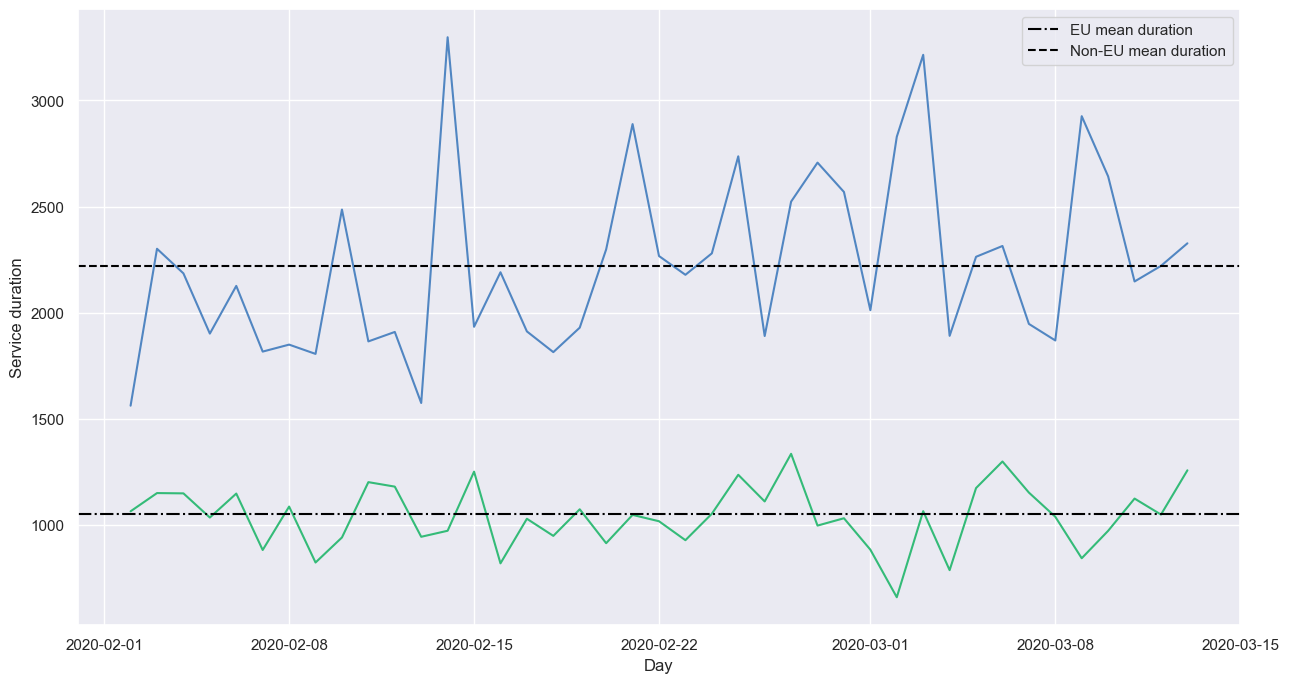

In [14]:
plt.figure(figsize=(15,8))

eu = sns.lineplot(data = eu_service.groupby(pd.Grouper(key='calc_created', freq='1D'))['duration'].mean(),
             color='#34BB78',
             )
eu.set(xlabel='Day',
       ylabel='Service duration'
       )
plt.axhline(1052,
            color='black',
            linestyle='-.',
            label='EU mean duration'
            )

noneu = sns.lineplot(data = noneu_service.groupby(pd.Grouper(key='calc_created', freq='1D'))['duration'].mean(),
                     color='#5186C2'
                     )
plt.axhline(2220,
            color='black',
            linestyle='dashed',
            label='Non-EU mean duration'
            )


plt.legend()

On the continuous line chart above, we have two main findings: the argument that markets have different patterns -- the uptake in the demands barely coincides across regions. Secondly, we see the preserved pattern picked up above: the service's duration is higher on particular days in both regions. In theory, the spikes could be a metric for the increased surge.

We established days when the demand might be increased, now let us check the duration of the services during the week.
A similar pattern is observed, as for the general scale, the predictions for durations are also under-predicting for both regions. What is more concerning is that aggregated predicted values resemble constants; this is vividly depicted for the non-EU region: while duration seems to increase on Fridays (2569), the prediction is almost twice as low (1484).

So, at this stage, it is clear that Hypothesis 1 finds support in the data, but the final assessment will be made in the second step.

<br>

### Hypothesis 2

Moving to the hours, when the order is made (__H2__), same approach as before!

Text(0.5, 1.02, 'From 9 to 5, and then Company\n Histogram for orders throughout the day in EU and non-EU regions')

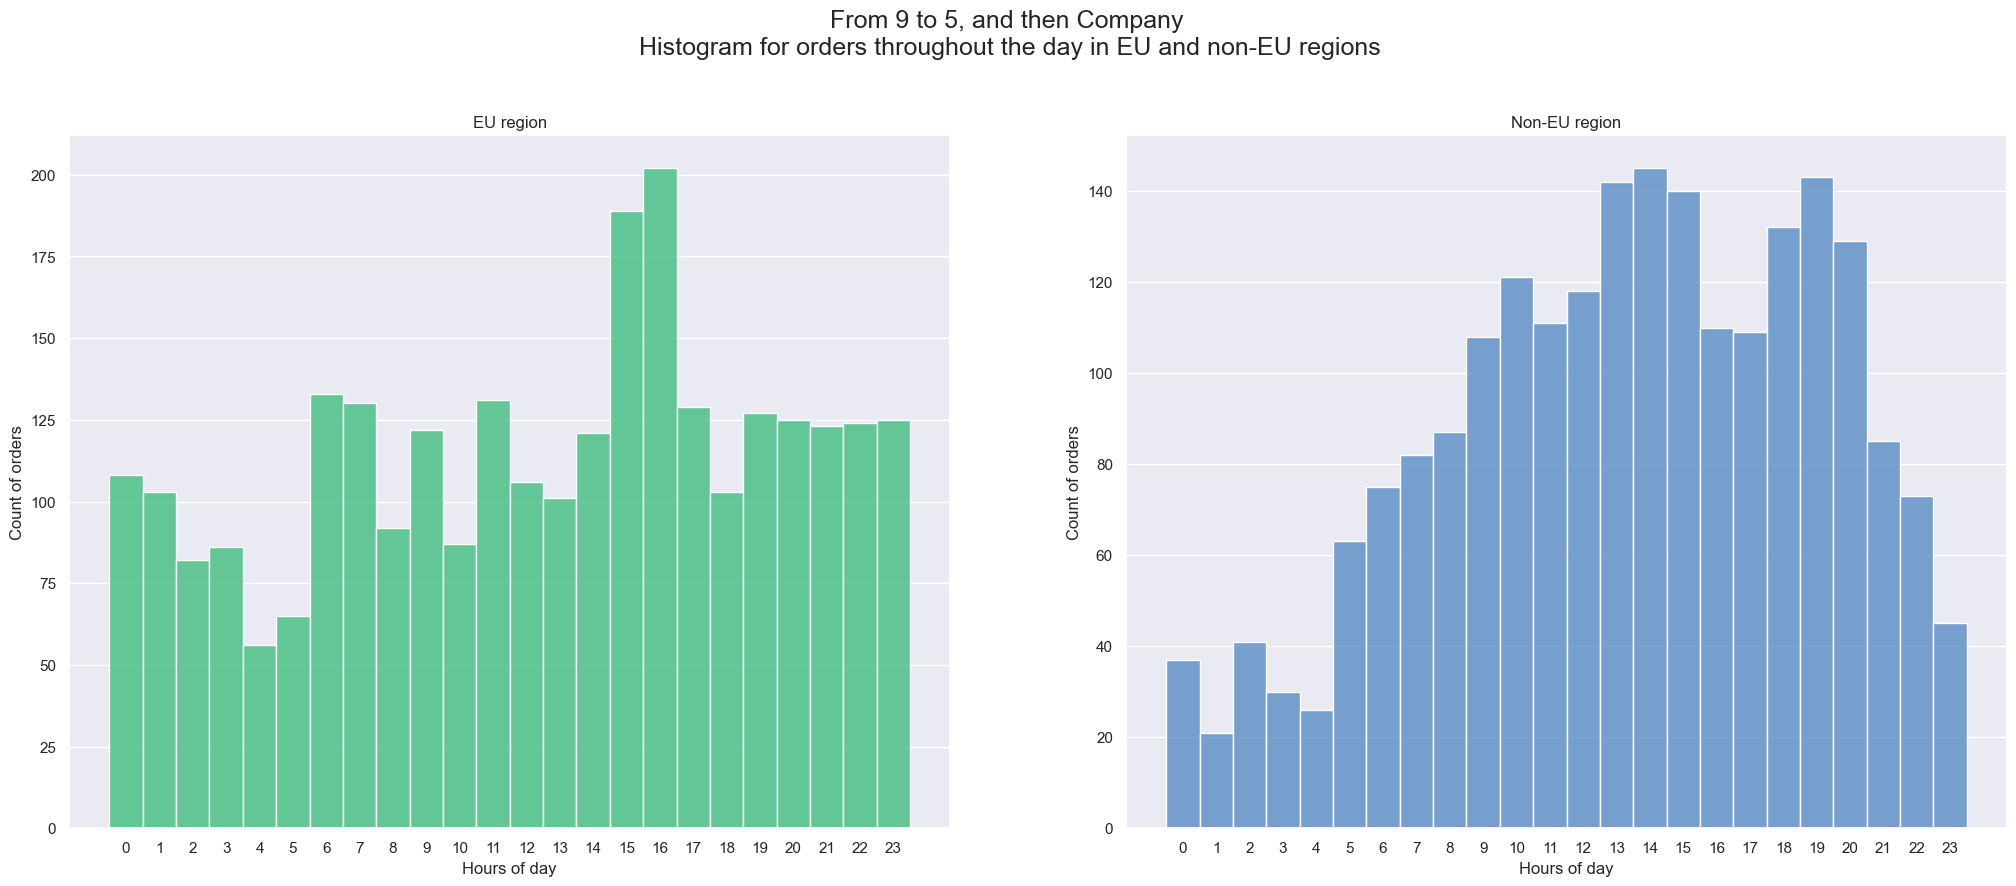

In [15]:
fig, axs = plt.subplots(ncols=2)

sns.histplot(data=eu_service,
             x=eu_service.calc_created.dt.hour,
             bins=24,
             ax=axs[0],
             binwidth=1,
             binrange=(-0.5, 23.5),
             color='#34BB78'
             )
axs[0].set(xlabel='Hours of day',
           ylabel='Count of orders',
           title='EU region'
           )
axs[0].set_xticks(range(24))
axs[0].xaxis.grid(False)

sns.histplot(data=noneu_service,
             x=noneu_service.calc_created.dt.hour,
             bins=24,
             ax=axs[1],
             binwidth=1,
             binrange=(-0.5, 23.5),
             color='#5186C2'
             )
axs[1].set(xlabel='Hours of day',
           ylabel='Count of orders',
           title='Non-EU region'
           )
axs[1].set_xticks(range(24))
axs[1].xaxis.grid(False)


fig.suptitle(f'From 9 to 5, and then Company{os.linesep} Histogram for orders throughout the day in EU and non-EU regions', y=1.02, fontsize=18)

In the same manner, as it was observed about the days of the week, there is a difference between the EU and non-EU samples:
- clients in the EU member states are the most active around 3-4 PM, which would be 5-6 PM if the initial values were in the UTC timezone;
- on the contrary, the non-EU region has two spikes, 1-3 PM and 6-8 PM, a similar conversion of timezones is applicable.

Text(0.5, 1.02, "From 9 to 5, and then Company\n Overlapping barplots for service' durations throughout the day in EU and non-EU regions")

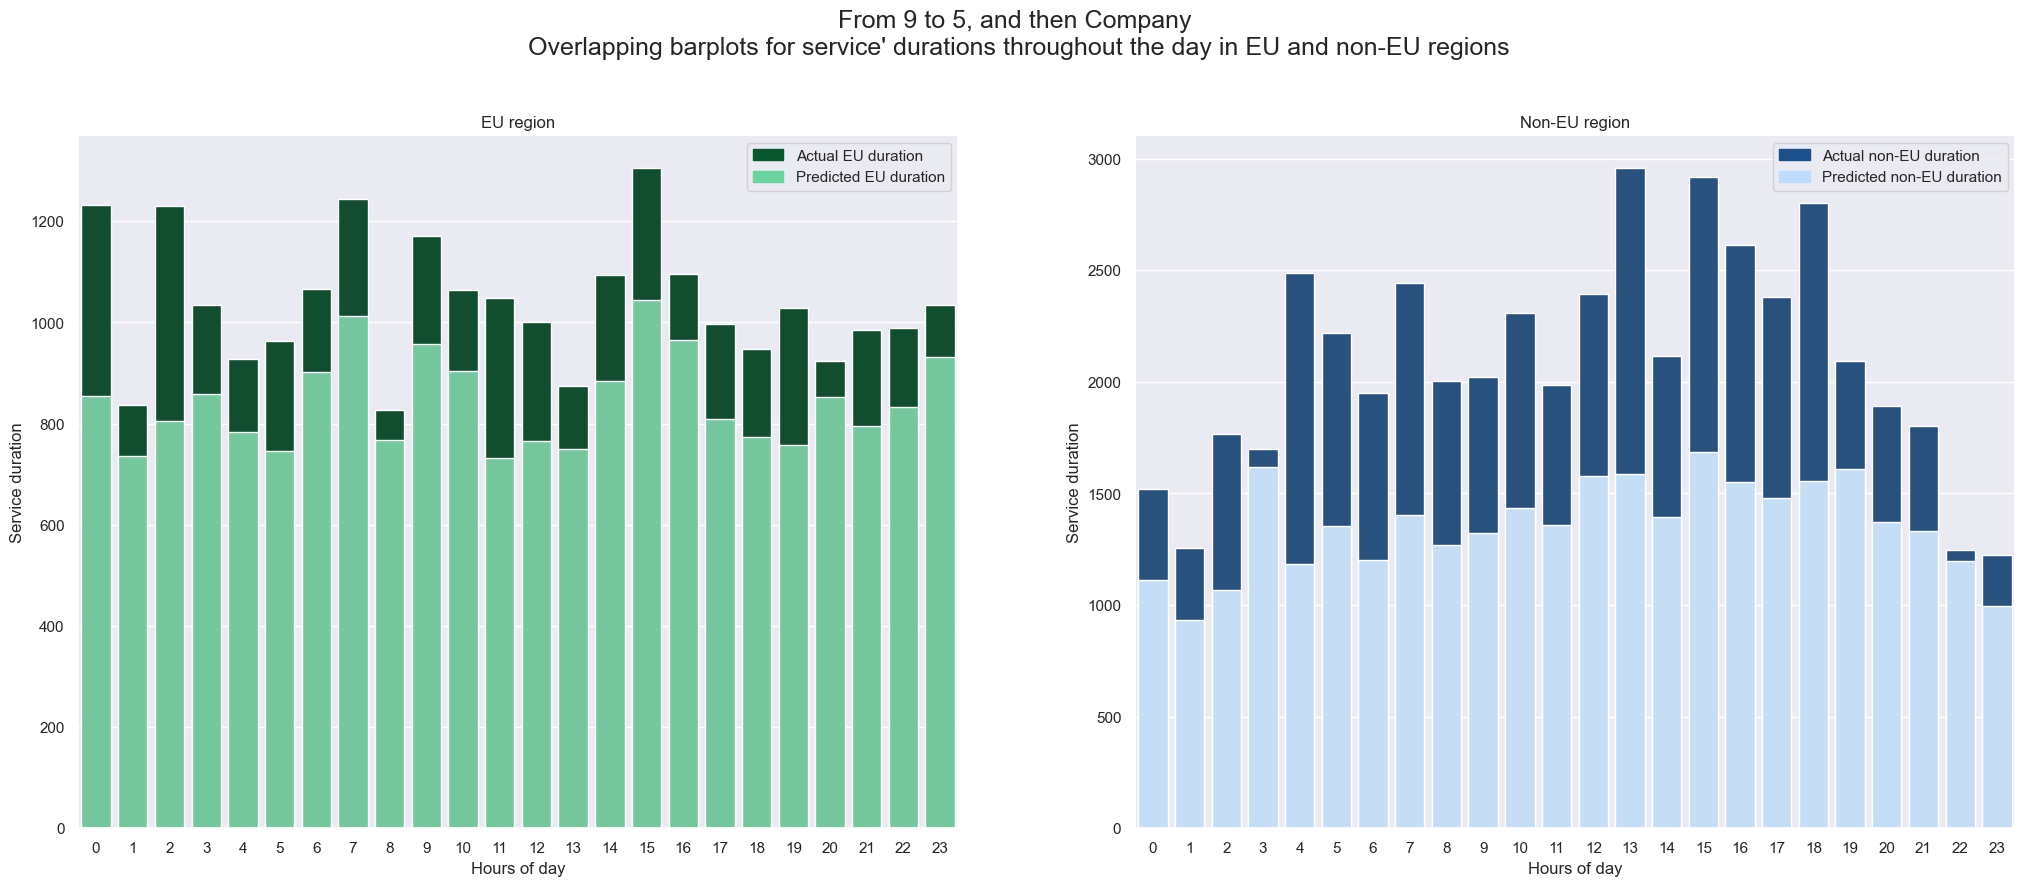

In [16]:
fig, axs = plt.subplots(ncols=2)

sns.barplot(data=eu_service,
            x=eu_service.calc_created.dt.hour,
            y='duration',
            ax=axs[0],
            ci=False,
            color='#07572F'
            )

sns.barplot(data=eu_service,
            x=eu_service.calc_created.dt.hour,
            y='predicted_duration',
            ax=axs[0],
            ci=False,
            color='#68D49E'
            )
axs[0].set(xlabel='Hours of day',
           ylabel='Service duration',
           title='EU region'
           )
axs[0].legend(handles=[EU_actual, EU_predicted])

sns.barplot(data=noneu_service,
            x=noneu_service.calc_created.dt.hour,
            y='duration',
            ax=axs[1],
            ci=False,
            color='#1B508C'
            )

sns.barplot(data=noneu_service,
            x=noneu_service.calc_created.dt.hour,
            y='predicted_duration',
            ax=axs[1],
            ci=False,
            color='#BEDCFE'
            )
axs[1].set(xlabel='Hours of day',
           ylabel='Service duration',
           title='Non-EU region'
           )
axs[1].legend(handles=[non_EU_actual, non_EU_predicted])

fig.suptitle(f"From 9 to 5, and then Company{os.linesep} Overlapping barplots for service' durations throughout the day in EU and non-EU regions", y=1.02, fontsize=18)

In [17]:
pt_duration = pd.pivot_table(data=df,
                             values=['duration'],
                             index='eu_indicator',
                             columns=df.calc_created.dt.hour
                             )
pt_pre_dur = pd.pivot_table(data=df,
                            values=['predicted_duration'],
                            index='eu_indicator',
                            columns=df.calc_created.dt.hour
                            )

pt_duration = pt_duration.rename(index={0:'non-EU', 1:'EU'})
pt_pre_dur = pt_pre_dur.rename(index={0:'non-EU', 1:'EU'})

display(pt_duration, pt_pre_dur)

duration                                                      \
calc_created           0            1            2            3            4    
eu_indicator                                                                    
non-EU        1521.837838  1255.380952  1766.073171  1697.566667  2485.230769   
EU            1232.703704   836.029126  1229.926829  1034.720930   927.500000   

                                                                               \
calc_created           5            6            7            8            9    
eu_indicator                                                                    
non-EU        2217.095238  1950.706667  2441.817073  2001.229885  2019.185185   
EU             963.553846  1065.353383  1244.200000   826.880435  1171.409836   

              ...                                                      \
calc_created  ...           14           15           16           17   
eu_indicator  ...                                                       
non-EU        ...  2115.931034  2917.742857  2613.227273  2377.844037   
EU            ...  1093.876033  1304.566138  1094.702970   997.527132   

                                                                               \
calc_created           18           19           20           21           22   
eu_indicator                                                                    
non-EU        2802.871212  2094.615385  1893.511628  1801.364706  1248.616438   
EU             948.213592  1029.314961   923.720000   984.780488   988.088710   

                           
calc_created           23  
eu_indicator               
non-EU        1225.555556  
EU            1033.888000  

[2 rows x 24 columns]

predicted_duration                                        \
calc_created                 0           1            2            3    
eu_indicator                                                            
non-EU              1110.378378  932.619048  1069.317073  1619.366667   
EU                   855.247619  736.242718   805.219512   857.494118   

                                                                               \
calc_created           4            5            6            7            8    
eu_indicator                                                                    
non-EU        1183.461538  1352.968254  1202.666667  1403.256098  1270.689655   
EU             783.446429   745.873016   901.416667  1011.930769   768.230769   

                           ...                                         \
calc_created           9   ...           14           15           16   
eu_indicator               ...                                          
non-EU        1321.175926  ...  1393.558621  1685.892857  1549.345455   
EU             956.713115  ...   883.216667  1043.941489   965.701493   

                                                                               \
calc_created           17           18           19           20           21   
eu_indicator                                                                    
non-EU        1480.495413  1554.772727  1610.146853  1372.790698  1332.470588   
EU             808.320312   773.679612   756.658730   852.992000   794.685950   

                                       
calc_created           22          23  
eu_indicator                           
non-EU        1198.986301  994.911111  
EU             832.113821  931.406504  

[2 rows x 24 columns]

While comparing the mean actual and predicted durations, we also see that expected values lag and do not capture the "historical" duration. If the EU sample has a similar value, non-EU once again occasionally barely captures half of the duration (e.g., aggregated values for 1 PM and 3 PM).

A "By-hour" chart is not created for this section since it will be hardly readable.

<br>

### Hypothesis 3

The third assumption revolves around the fact that `upfront_price` might be underestimating distance because of the `gps_confidence`, which might depend on the `device_name` and `service_app_version`. Plus, I will assess which phones are used in EU and non-EU regions; maybe this split will share some light on the predictions.

The structure is following:
1. Is there a statically significant difference between GPS-accurate and GPS-inaccurate samples?
2. Which region has more "errors" in GPS tracking?
3. Which phones are more susceptible to low confidence in GPS?
4. How application's version and `gpd_confidence` are intertwined?

In [18]:
result_gps = mannwhitneyu(df[df['gps_confidence'] == 0]['predicted_duration'].dropna(), df[df['gps_confidence'] == 1]['predicted_duration'].dropna())
print('t-statistic:', result_gps.statistic)
print('p-value:', result_gps.pvalue)

t-statistic: 2776816.0
p-value: 1.2472514881840942e-98


By running the Mann-Whitney t-test for independent samples (based on different geographical units), I establish the presence of a statistically significant difference for predicted duration across services with good and bad GPS connections.

[Text(0, 0, '127'), Text(0, 0, '2643')]

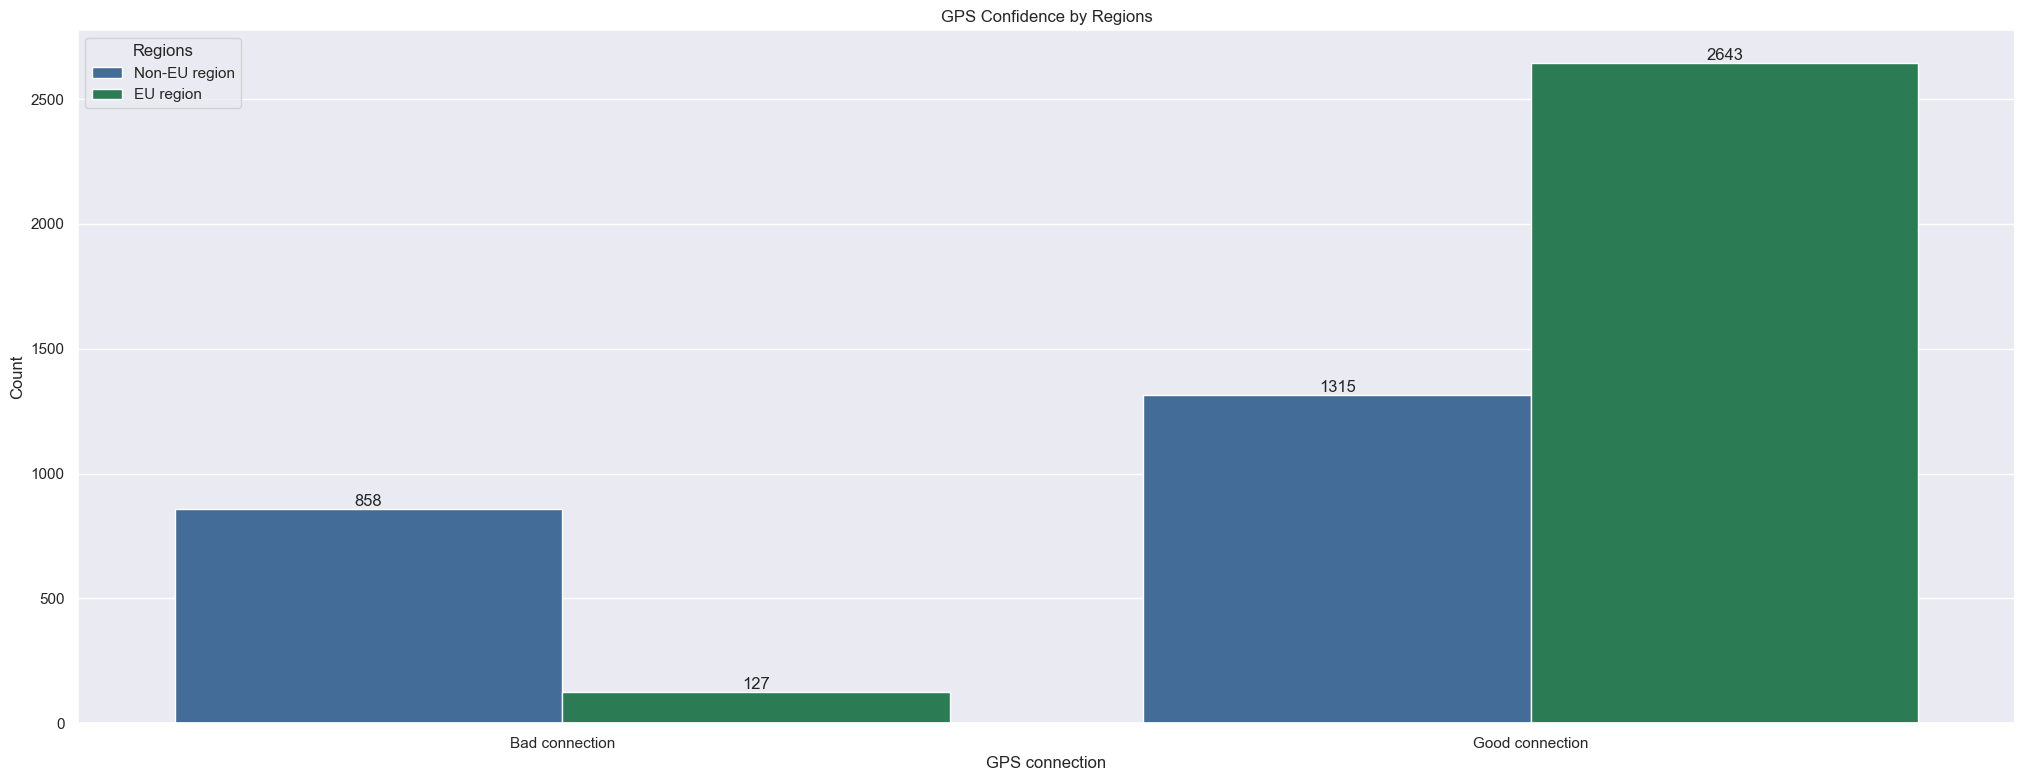

In [19]:
g = sns.countplot(data=df,
                  x='gps_confidence',
                  hue='eu_indicator',
                  palette=['#366BA7', '#1E8954']
                  )

plt.xticks([0, 1], ['Bad connection', 'Good connection'])

legend_labels = ['Non-EU region', 'EU region']
plt.legend(title='Regions', labels=legend_labels)

plt.title('GPS Confidence by Regions')
plt.xlabel('GPS connection')
plt.ylabel('Count')

g.bar_label(g.containers[0])
g.bar_label(g.containers[1])

Also, despite the number of services for non-EU and EU regions, it is clear that non-EU has more issues with a stable GPS connection.

In [20]:
table = pd.pivot_table(data=df,
                       values='device_name',
                       index='eu_indicator',
                       columns='gps_confidence',
                       aggfunc='count',
                       margins=True
                       )
table = table.rename({0:'bad_connection', 1:'good_connection'}, axis=1).rename(index={0:'non-EU', 1:'EU'})
table.div(table.iloc[:,-1], axis=0)

gps_confidence,bad_connection,good_connection,All
eu_indicator,,,
non-EU,0.394846,0.605154,1.0
EU,0.045848,0.954152,1.0
All,0.199272,0.800728,1.0


In the EU, the share of bad GPS connections is __ten times smaller__ than in the non-EU region. So it seems that bad connection is a mostly non-EU issue; let us find out if it has something to do with the phones!

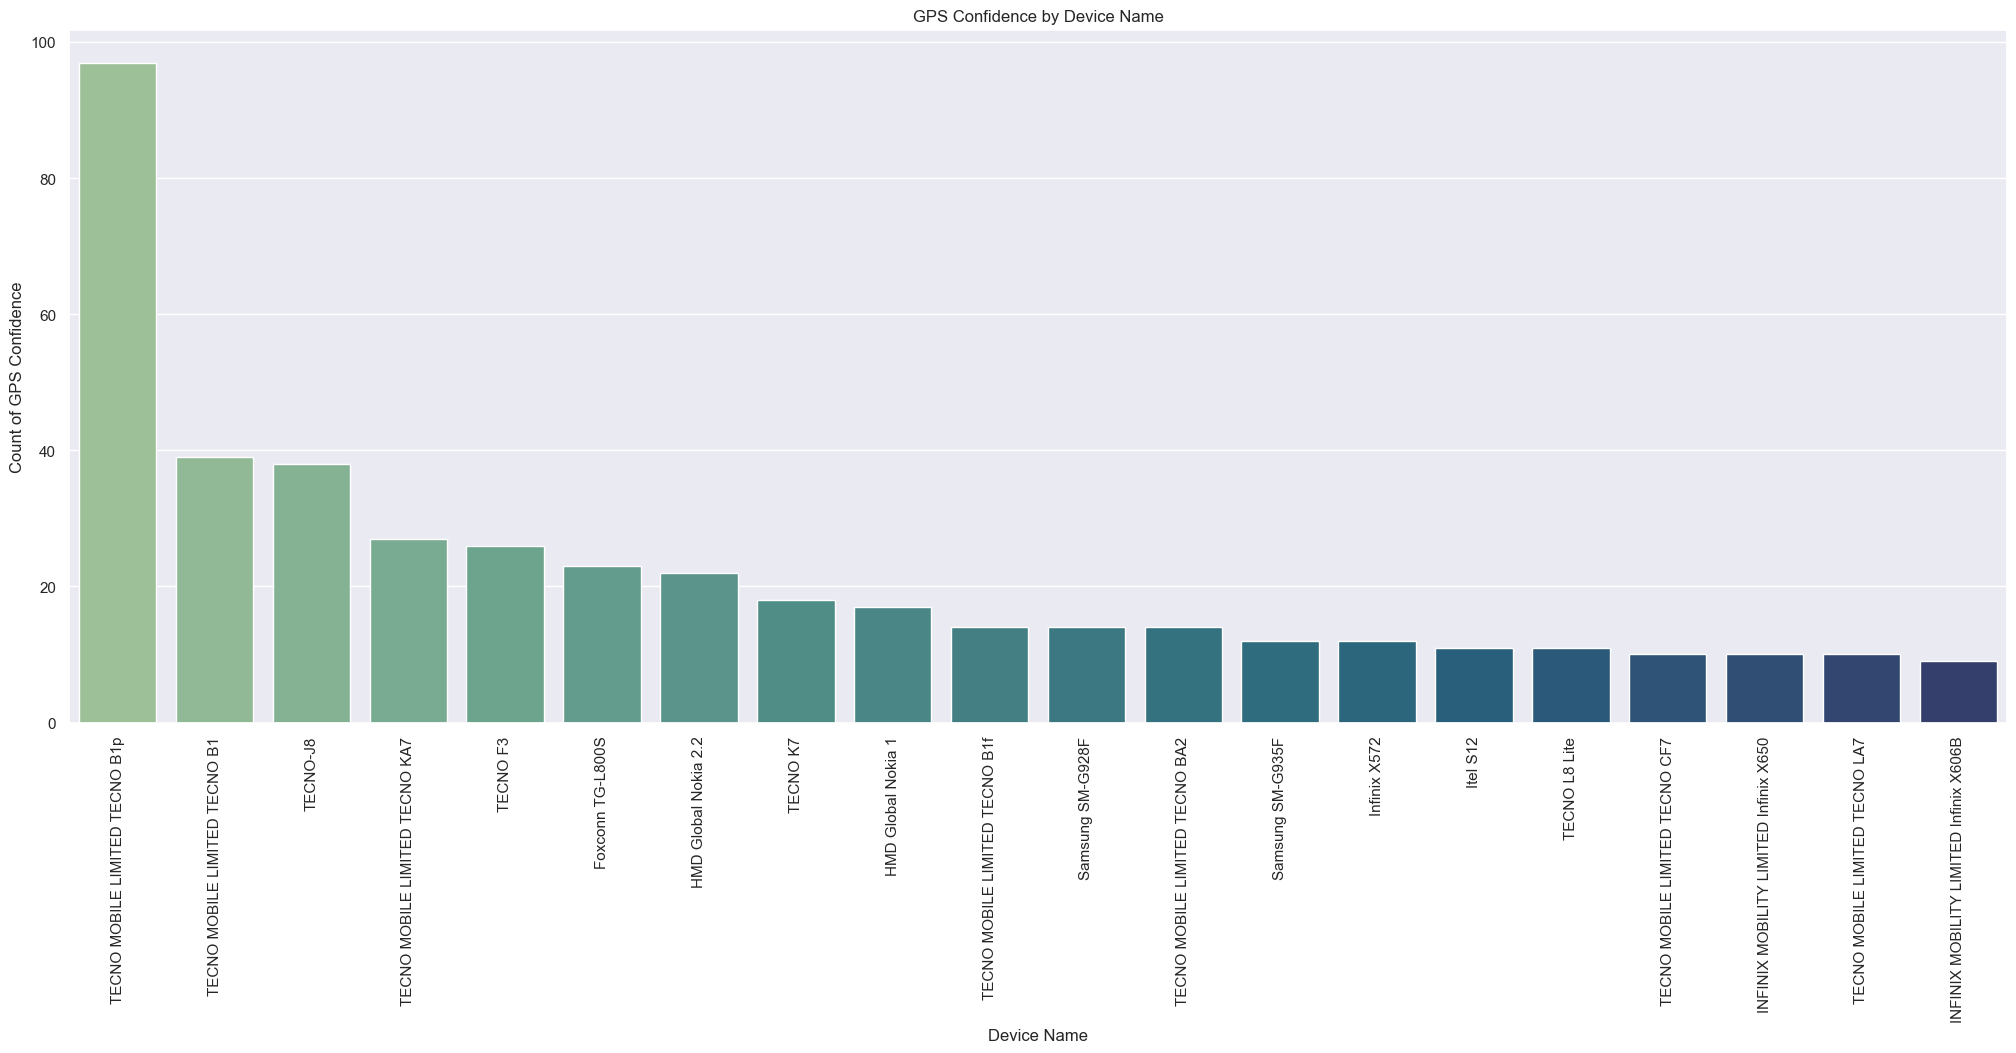

In [21]:
grouped = df[(df['gps_confidence'] == 0) & (df['eu_indicator'] == 0)].groupby('device_name')['gps_confidence'].count().reset_index()

g = sns.barplot(data=grouped.sort_values(by='gps_confidence', ascending=False)[:20],
                x='device_name',
                y='gps_confidence',
                palette='crest'
                )
g.set(xlabel='Device Name',
      ylabel='Count of GPS Confidence',
      title='GPS Confidence by Device Name'
      )
plt.xticks(rotation=90)
plt.show()

In [22]:
table = pd.pivot_table(data=df[(df['gps_confidence'] == 0) & (df['eu_indicator'] == 0)],
                       values=['gps_confidence', 'distance', 'predicted_distance'],
                       index='device_name',
                       aggfunc=['count', 'mean'],
                       fill_value=0
                       )
table.rename({0:'non_EU', 1:'EU'}, axis=1).sort_values(by=('count','gps_confidence'), ascending=False).drop([('count','distance'), ('count','predicted_distance'), ('mean','gps_confidence')], axis=1).head(20)

count          mean  \
                                       gps_confidence      distance   
device_name                                                           
TECNO MOBILE LIMITED TECNO B1p                     97  14833.814433   
TECNO MOBILE LIMITED TECNO B1                      39  16887.615385   
TECNO-J8                                           38  14266.684211   
TECNO MOBILE LIMITED TECNO KA7                     27  12685.037037   
TECNO F3                                           26   9481.000000   
Foxconn TG-L800S                                   23  13444.608696   
HMD Global Nokia 2.2                               22   8722.681818   
TECNO K7                                           18  13034.388889   
HMD Global Nokia 1                                 17  31758.588235   
TECNO MOBILE LIMITED TECNO B1f                     14  12147.571429   
Samsung SM-G928F                                   14   5871.928571   
TECNO MOBILE LIMITED TECNO BA2                     14  12060.928571   
Samsung SM-G935F                                   12  21690.416667   
Infinix X572                                       12   8866.583333   
Itel S12                                           11  11264.636364   
TECNO L8 Lite                                      11   8236.636364   
TECNO MOBILE LIMITED TECNO CF7                     10   6998.200000   
INFINIX MOBILITY LIMITED Infinix X650              10   9701.300000   
TECNO MOBILE LIMITED TECNO LA7                     10   8283.800000   
INFINIX MOBILITY LIMITED Infinix X606B              9  17853.000000   

                                                           
                                       predicted_distance  
device_name                                                
TECNO MOBILE LIMITED TECNO B1p                9522.536082  
TECNO MOBILE LIMITED TECNO B1                11767.538462  
TECNO-J8                                      8280.921053  
TECNO MOBILE LIMITED TECNO KA7                8968.481481  
TECNO F3                                     12065.653846  
Foxconn TG-L800S                             11900.086957  
HMD Global Nokia 2.2                         10544.272727  
TECNO K7                                     12603.166667  
HMD Global Nokia 1                            8822.470588  
TECNO MOBILE LIMITED TECNO B1f               13767.928571  
Samsung SM-G928F                              7075.642857  
TECNO MOBILE LIMITED TECNO BA2               10408.428571  
Samsung SM-G935F                             16587.416667  
Infinix X572                                  8806.250000  
Itel S12                                      6795.727273  
TECNO L8 Lite                                 7777.818182  
TECNO MOBILE LIMITED TECNO CF7                8311.000000  
INFINIX MOBILITY LIMITED Infinix X650         9689.300000  
TECNO MOBILE LIMITED TECNO LA7               11446.100000  
INFINIX MOBILITY LIMITED Infinix X606B       14243.666667

TECNO phones have the most frequent cases of bad GPS connection. However, I would like to note that this finding does not entail that the telephone is terrible — I cannot make any causality claims. It might be the case that all TECNO users live in regions with poor coverage. Yet, this is a good prediction for the model; the model could capture the cases when the user might be vulnerable to a bad connection.

According to the phone models and Google searches, I assume that the dataset has data on the cities and not regions or countries, and the non-EU city is in Africa.

However, I reckon that one more step should be made to get to the root of the problem. A phone is just a device, which has an embedded GPS tracking function, but what if it is not the phone, but the version of the app, which might be buggy or outdated?

In [23]:
table = pd.pivot_table(df[(df['gps_confidence'] == 0) & (df['eu_indicator'] == 0)],
                       values=['gps_confidence'],
                       index=['device_name', 'rider_app_version'],
                       aggfunc=['count'],
                       fill_value=0
                       )
table.sort_values(by=('count','gps_confidence'), ascending=False)

count
                                                 gps_confidence
device_name                    rider_app_version               
TECNO MOBILE LIMITED TECNO B1p CA.5.36                       12
                               CA.5.42                       12
                               CA.5.44                        9
                               CI.4.19                        9
TECNO-J8                       CA.5.44                        8
...                                                         ...
Samsung SM-G6100               CA.5.43                        1
                               CA.5.36                        1
                               CA.5.04                        1
Samsung SM-G570F               CI.4.22                        1
iPhone9,4                      CA.4.58                        1

[510 rows x 1 columns]

We are aware that TECHNO B1p is the most problematic device, with 97 cases of bad GPS connection. Nevertheless, 42 out of 97 cases had a particular app version, which could affect the functionality of the application. For a more justified conclusion, more information is required, yet at this stage, it seems that the issue is mostly in devices because version __'CA.5.44'__ (97) and __'CA.5.42'__ (71) are the most frequent in the non-EU sample with bad GPS connection.

In [24]:
sorted = df[(df['eu_indicator'] == 0) & (df['gps_confidence'] == 0)]
sorted.rider_app_version.value_counts().head()

CA.5.44    97
CA.5.42    71
CI.4.19    65
CA.5.36    62
CA.5.43    62
Name: rider_app_version, dtype: int64

<br>

### Summary

As the preliminary conclusion, within the first part of the home assignment, I was able to extract at least four new features, which are not considered for the current calculation of `upfront_price` and its main underlying features, `predicted_duration` and `predicted_distance`.
1. _Hour when the order was made_ must be considered in the model, so it would capture the hypothetical rush hours situations on the road, as well as an increase in the demand from the Company users;
2. _Weekday when the order was made_ would be more significant on the bigger dataset since we saw the seasonality in the order surge and hypothetical duration of the trip for both regions;
    Speaking of seasonality, if there were more data across seasons, the _month_ variable would be a must-have
3. _Phone model_ and _GPS connection_ -- these are the two directly connected variables to the distance of the service. If the GPS connection is not stable, then it is barely possible to track the user's location, and this is connected to the phone model. In comparison to the `hour` and `weekday`, the inclusion of the `device_name` in the model would require one-hot encoding of the models, but maybe it would be easier to include only the most unreliable models or keep the brand name, without a particular model.
    Also, as a side comment, on the day when I received the task, I addressed several questions to Karl, and while working on the task, I responded to one of them about the missing values for `upfront_price`.
    There are 4934 observations in the data with the main label of `upfront_price`, but at the same time, there are 1534 missing values for the variable. It seems that the prediction cannot be made without a good GPS connection; see output below for non-predicted `upfront_price`. This explanation covers at least 40% of missing cases, the other cases could be covered if I would get more technical information for categories `upfront` and `prediction` in the `prediction_price_type` and `user_app_version`, which I assume is connected to the GPS connection stability.
4. _EU and non-EU_ is the last and the most significant variable, which was the red thread throughout the analysis. This variable does not only carry the differences in currencies, time of orders, and devices, but also latently illustrates the differences in the sizes of the market, sizes of the countries, and income. So, in theory, all the abovementioned variables are embedded in this juxtaposition, and I will show it in the next task.

These are the main conceptual variables that should be embedded in the model for improved performance. However, I would like to test these findings by testing the models with the indicators. Finally, at least one technical, data-related opportunity would improve the performance.

In [25]:
upfront_nan = df[df.upfront_price.isna()].reset_index(drop=True)
upfront_nan.shape

(1534, 26)

In [26]:
table = pd.pivot_table(data=upfront_nan[upfront_nan.gps_confidence == 0],
                       values='gps_confidence', index=['device_name'],
                       columns='eu_indicator',
                       aggfunc='count',
                       fill_value=0,
                       margins=True)
table.rename({0:'non_EU', 1:'EU'}, axis=1).sort_values(by='non_EU', ascending=False).head(10)

eu_indicator,non_EU,EU,All
device_name,,,
All,561,52,613
TECNO MOBILE LIMITED TECNO B1p,54,0,54
TECNO-J8,30,0,30
TECNO MOBILE LIMITED TECNO B1,25,0,25
HMD Global Nokia 2.2,20,0,20
TECNO MOBILE LIMITED TECNO KA7,19,0,19
TECNO F3,19,0,19
Foxconn TG-L800S,17,0,17
HMD Global Nokia 1,15,0,15


<br>

<br>


# Step 2. Data science
## _To Data analysis and Beyond_

The idea for this section is to test the empirical impact of the extracted insights on the quality of predictions. As an option, the Machine Learning techniques could be replaced with Regression analysis, which would be limited in scope and less explicit.

The plan for the task is the following:
1. First of all, I will start by __preparing data__ for the analysis: removing missing values, omitting irrelevant columns, etc.;
2. Based on the results of the Data analysis, I will conduct __feature engineering__ and add the variables mentioned above to our data;
3. The last step is establishing the prediction baseline for our upfront price and checking if and how the output is affected by adding new variables.

# Data preparation
Within this section, I will go through the basic steps for preparing data for further analysis:
- finding duplicates;
- managing missing values;
- removing irrelevant columns from the dataset

In [27]:
df_cleaned = df.copy()
print(df_cleaned.shape)

(4943, 26)


### Duplicates

In [28]:
df_cleaned[df_cleaned.duplicated('order_id_new')].sort_values('order_id_new')

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,...,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
1902,3,3,2020-02-02 00:49:24,14.87,NaN,15541,1690,0,client,finished,...,NaN,CI.4.17,finished,finished,DA.4.37,1257,Samsung SM-J415FN,1,0,-1516.0
2299,13,13,2020-02-02 02:31:56,8.89,NaN,16880,1339,1,driver,finished,...,NaN,CI.4.17,finished,finished,DA.4.31,858,HUAWEI P7-L10,1,0,-196.0
4636,19,19,2020-02-02 02:59:48,6.69,5.3,9498,793,1,client,finished,...,NaN,CA.5.42,finished,finished,DA.4.37,301,Xiaomi Redmi Note 7,1,0,-316.0
2585,26,26,2020-02-02 06:44:20,6000.00,8500.0,12,160,1,client,finished,...,NaN,CA.5.36,finished,finished,DA.4.37,1002,TECNO MOBILE LIMITED TECNO KC8,0,0,NaN
4861,26,26,2020-02-02 06:44:20,6000.00,8500.0,12,160,1,client,finished,...,NaN,CA.5.36,finished,finished,DA.4.37,1002,TECNO MOBILE LIMITED TECNO KC8,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3602,4127,4127,2020-03-13 17:14:49,15389.46,NaN,9908,2711,1,client,finished,...,NaN,CI.4.00,finished,finished,DA.4.42,1840,Samsung SM-G950F,0,0,NaN
4627,4136,4136,2020-03-13 19:23:44,15848.22,NaN,11639,2112,1,client,finished,...,NaN,CI.4.19,finished,finished,DA.4.42,359,Samsung SM-G950U,0,0,NaN
4543,4140,4140,2020-03-13 20:11:20,14.10,11.8,21181,1810,1,client,finished,...,NaN,CA.5.47,finished,finished,DA.4.42,551,Xiaomi Redmi 6A,1,0,NaN
4571,4154,4154,2020-03-13 22:08:42,2.60,3.7,2329,357,1,client,finished,...,NaN,CA.5.47,finished,finished,DA.4.31,1252,Xiaomi Redmi 6A,1,0,NaN


In [29]:
duplicates = df_cleaned.groupby('order_id_new', as_index=False).size()
duplicates[duplicates['size'] > 1].sort_values('size', ascending=False)

,order_id_new,size
63,63,6
3443,3443,6
774,774,5
1201,1201,5
761,761,5
...,...,...
1448,1448,2
1444,1444,2
1439,1439,2
1412,1412,2


Surprisingly, out of 4943 records in the dataset, there are 777 duplicating lines and 1389 including the unique observations. Moreover, some of the lines (i.e., records with ID 63 and 3443) have five repetitions in the data. In general, the duplicates are almost identical, apart from the `ticket_id_new` and occasional variance in the `overpaid_user_ticket`.
Since the repetitions do not bring variance in the variable distribution, it does make sense to remove them.

In [30]:
df_cleaned = df_cleaned.drop_duplicates(subset=['order_id_new'])
print(len(df_cleaned))
df_cleaned.head()

4166


,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,...,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,2020-02-02 03:37:31,4.04,10.0,2839,700,1,client,finished,...,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0
1,618,618,2020-02-08 02:26:19,6.09,3.6,5698,493,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN
2,657,657,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0
3,313,313,2020-02-05 06:34:54,72871.72,NaN,49748,1400,0,client,finished,...,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN
4,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,...,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN


<br>

### Missing values

In [31]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4166 entries, 0 to 4941
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id_new           4166 non-null   int64         
 1   order_try_id_new       4166 non-null   int64         
 2   calc_created           4166 non-null   datetime64[ns]
 3   metered_price          4147 non-null   float64       
 4   upfront_price          2946 non-null   float64       
 5   distance               4166 non-null   int64         
 6   duration               4166 non-null   int64         
 7   gps_confidence         4166 non-null   int64         
 8   entered_by             4166 non-null   object        
 9   b_state                4166 non-null   object        
 10  dest_change_number     4166 non-null   int64         
 11  prediction_price_type  4147 non-null   object        
 12  predicted_distance     4147 non-null   float64       
 13  pre

In [32]:
print(dict(df_cleaned.isna().sum().sort_values(ascending=False)))

{'device_token': 4166, 'change_reason_pricing': 3911, 'fraud_score': 2238, 'upfront_price': 1220, 'prediction_price_type': 19, 'predicted_distance': 19, 'predicted_duration': 19, 'metered_price': 19, 'rider_app_version': 15, 'gps_confidence': 0, 'overpaid_ride_ticket': 0, 'eu_indicator': 0, 'device_name': 0, 'driver_device_uid_new': 0, 'driver_app_version': 0, 'order_try_state': 0, 'order_state': 0, 'calc_created': 0, 'entered_by': 0, 'ticket_id_new': 0, 'order_try_id_new': 0, 'distance': 0, 'duration': 0, 'dest_change_number': 0, 'b_state': 0, 'order_id_new': 0}


The sample data has a column that does not have values at all — `device_token`, `change_reason_pricing` is missing 93% of the data, and `fraud_score` has only about 50% of the data.
What is more concerning in this sense is that our label, `upfront_price`, is also affected by NAs — ~30% of data is absent.

In theory, if the task was different, I would try to predict the `upfront_price` and fill in the gaps like that. However, I find it counterproductive here, so I will drop all the missing values.

<br>

### Removing irrelevant columns and missing values

By _'irrelevance'_ I imply the variables, which technically cannot explain the variance in the label, for example, categorical variables might have only one category. The data has three columns, which meet this criterion.

In [33]:
[df_cleaned[i].value_counts() for i in df_cleaned.select_dtypes(include=['object']) if len(df_cleaned[i].unique())  < 3]

[finished    4166
 Name: b_state, dtype: int64,
 finished    4165
 active         1
 Name: order_state, dtype: int64,
 finished    4166
 Name: order_try_state, dtype: int64]

In [34]:
df_cleaned.columns

Index(['order_id_new', 'order_try_id_new', 'calc_created', 'metered_price',
       'upfront_price', 'distance', 'duration', 'gps_confidence', 'entered_by',
       'b_state', 'dest_change_number', 'prediction_price_type',
       'predicted_distance', 'predicted_duration', 'change_reason_pricing',
       'ticket_id_new', 'device_token', 'rider_app_version', 'order_state',
       'order_try_state', 'driver_app_version', 'driver_device_uid_new',
       'device_name', 'eu_indicator', 'overpaid_ride_ticket', 'fraud_score'],
      dtype='object')

In [35]:
df_cleaned = df_cleaned.drop(['order_id_new', # id column
                              'order_try_id_new', # duplicating id column
                              'device_token', # missing values
                              'change_reason_pricing', # missing values
                              'fraud_score', # missing values
                              'b_state', # not enough variance
                              'order_state', # not enough variance
                              'order_try_state', # not enough variance
                              'ticket_id_new', # irrelevant int/float variable
                              'driver_device_uid_new', # irrelevant int/float variable
                              'rider_app_version', # irrelevant int/float variable
                              'overpaid_ride_ticket', # irrelevant int/float variable
                              'dest_change_number' # irrelevant int/float variable
                              ], axis=1
                             )

In [36]:
df_cleaned = df_cleaned.dropna()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2946 entries, 0 to 4941
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   calc_created           2946 non-null   datetime64[ns]
 1   metered_price          2946 non-null   float64       
 2   upfront_price          2946 non-null   float64       
 3   distance               2946 non-null   int64         
 4   duration               2946 non-null   int64         
 5   gps_confidence         2946 non-null   int64         
 6   entered_by             2946 non-null   object        
 7   prediction_price_type  2946 non-null   object        
 8   predicted_distance     2946 non-null   float64       
 9   predicted_duration     2946 non-null   float64       
 10  driver_app_version     2946 non-null   object        
 11  device_name            2946 non-null   object        
 12  eu_indicator           2946 non-null   int64         
dtypes: 

Once we prepared the data, we got 2946 observations with 18 variables, which are ready for further analysis. However, within this section, I would like to add significant variables, which were widely described in the previous section: `hour` and `weekday`. The `eu_indicator` and `gps_confidence` is already in the data, but I will not include the `device_name` since it is too cumbersome for this small task.


In [37]:
df_cleaned['hour'] = df_cleaned['calc_created'].dt.hour
df_cleaned['weekday'] = df_cleaned['calc_created'].dt.weekday
df_cleaned.head()

,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,prediction_price_type,predicted_distance,predicted_duration,driver_app_version,device_name,eu_indicator,hour,weekday
0,2020-02-02 03:37:31,4.04,10.0,2839,700,1,client,upfront,13384.0,1091.0,DA.4.37,Xiaomi Redmi 6,1,3,6
1,2020-02-08 02:26:19,6.09,3.6,5698,493,1,client,upfront,2286.0,360.0,DA.4.39,Samsung SM-G965F,1,2,5
2,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,upfront,4101.0,433.0,DA.4.37,Samsung SM-A530F,1,11,5
4,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,upfront,14236.0,2778.0,DA.4.37,Itel W5504,0,17,3
5,2020-02-14 01:27:01,6.11,6.3,4924,513,1,client,upfront,4882.0,562.0,DA.4.39,HUAWEI WAS-LX1,1,1,4


<br>

# Prediction assessment

<AxesSubplot: xlabel='upfront_price', ylabel='predicted_distance'>

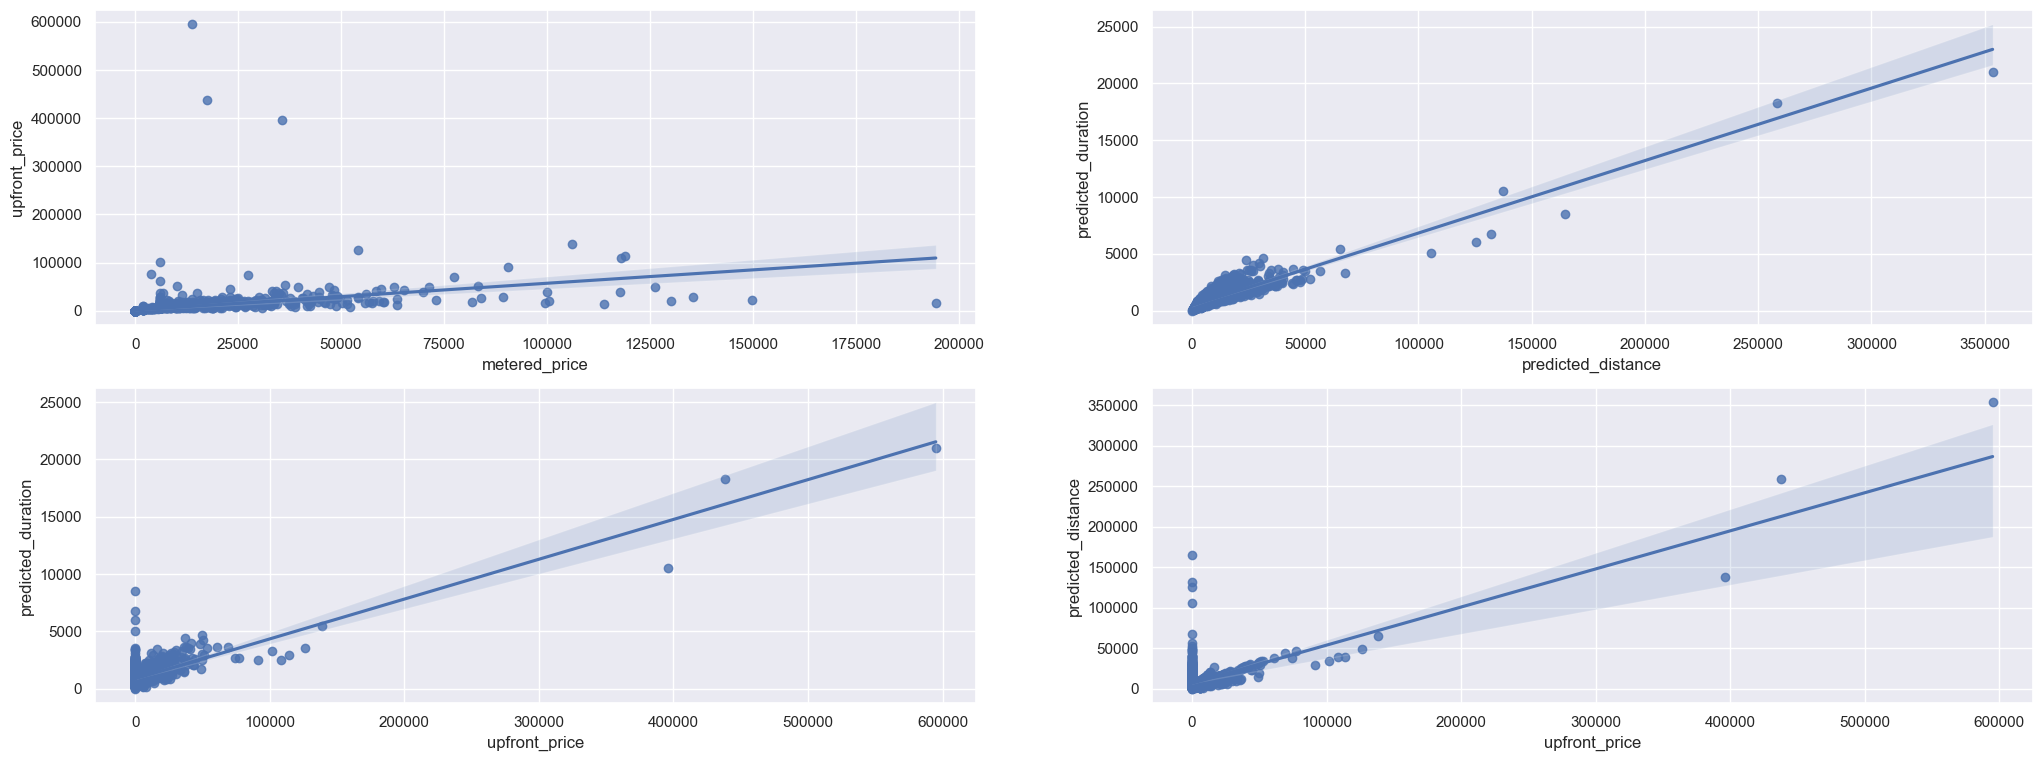

In [38]:
fig, axs = plt.subplots(ncols=2, nrows=2)

sns.regplot(data=df_cleaned,
            x='metered_price',
            y='upfront_price',
            ax=axs[0, 0]
            )

sns.regplot(data=df_cleaned,
            x='predicted_distance',
            y='predicted_duration',
            ax=axs[0, 1]
            )

sns.regplot(data=df_cleaned,
            x='upfront_price',
            y='predicted_duration',
            ax=axs[1, 0]
            )

sns.regplot(data=df_cleaned,
            x='upfront_price',
            y='predicted_distance',
            ax=axs[1, 1]
            )

<AxesSubplot: >

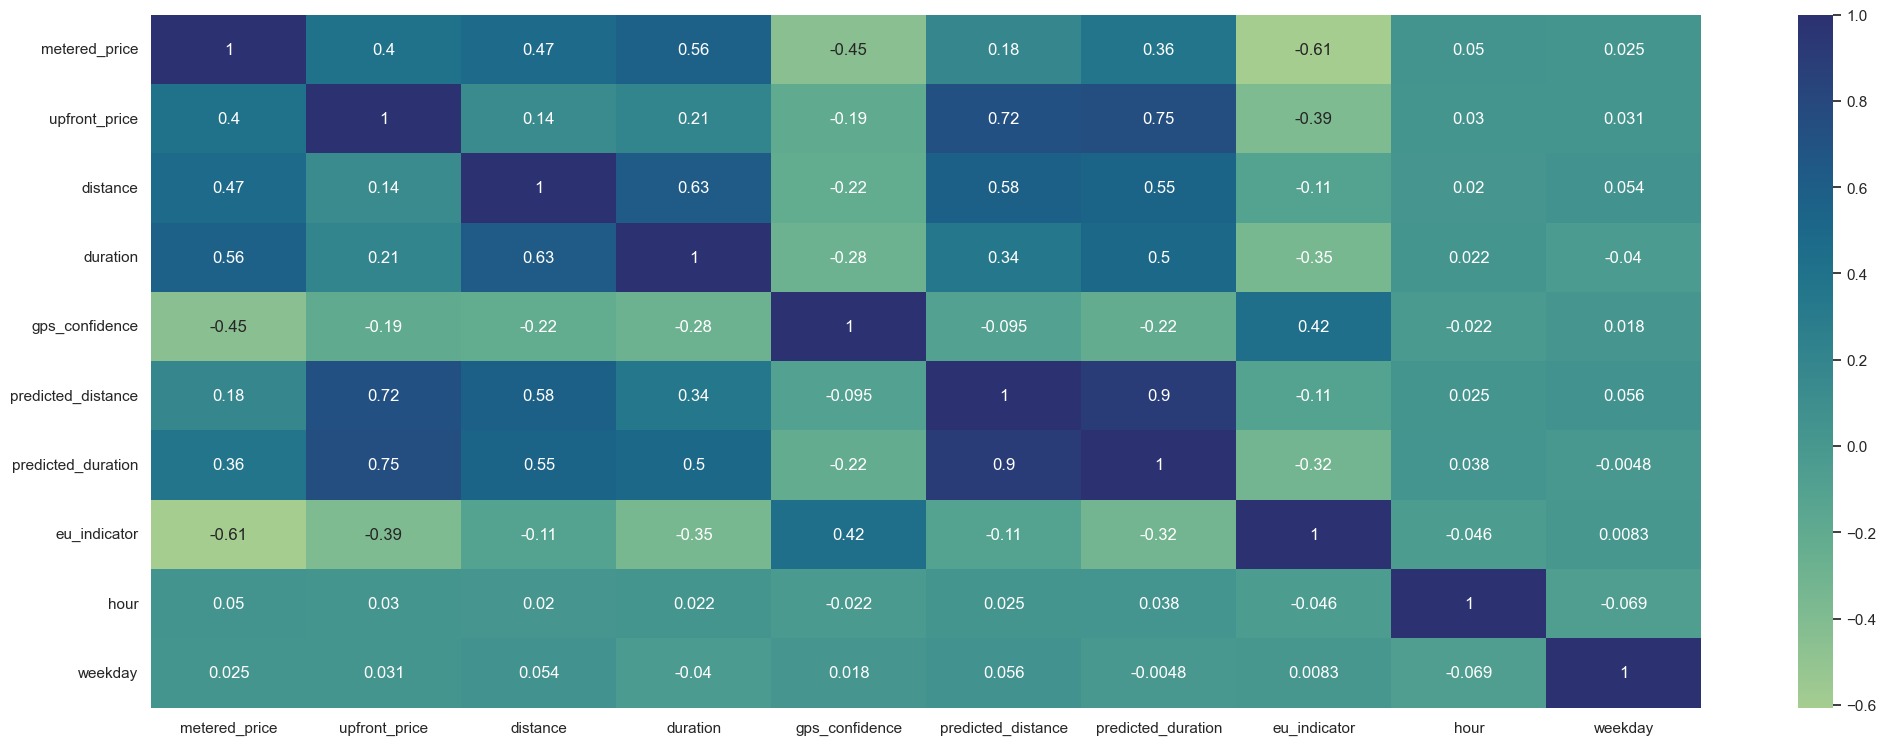

In [39]:
sns.heatmap(df_cleaned.corr(),
            annot=True,
            cmap='crest'
            )

I selected three regression models based on state-of-the-art: Linear, Decision Tree, and bagging for Trees — Random Forest. Additionally, as it stems from the plot above, there is a visual linear association between the variables in the basic model, which justifies using the Linear model.

The core assumption here is that we would like our `upfront_price` to be closer to `metered_price`; that is why I train our model with `metered_price` labels. Although there are no significant correlations between `meetered_price` and predicted variables, I will show that the performance will improve. Another technical remark is that I do not normalize the `price` data since it would be counterintuitive since these are two different currencies, and normalization would bring them to the "common" currency, which does not make sense and cannot be interpreted.

Let me also clarify that I intentionally do not use hyperparameter tuning for the models, and neither do I normalize the data. The section aims to assess the impact of variables on the `upfront_price` via the default models.

In [40]:
models = {'Linear Regression': LinearRegression(),
          'Decision Tree': DecisionTreeRegressor(),
          'Random Forest': RandomForestRegressor()
          }

error_list = []

<br>

### Baseline model

This is the simplest model, constructed from the tasks description: `upfront_price ~ predicted_duration + predicted_distance`. Despite the multicollinearity, I still include both variables in the model.

In [41]:
X = df_cleaned[['predicted_duration', 'predicted_distance']]
y = df_cleaned['metered_price']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=904
                                                    )

Baseline MAE for Linear Regression model: 5465.507 Baseline MSE for Linear Regression model: 153400198.608 

Baseline MAE for Decision Tree model: 5560.246 Baseline MSE for Decision Tree model: 228187171.876 

Baseline MAE for Random Forest model: 4909.067 Baseline MSE for Random Forest model: 158933087.901 



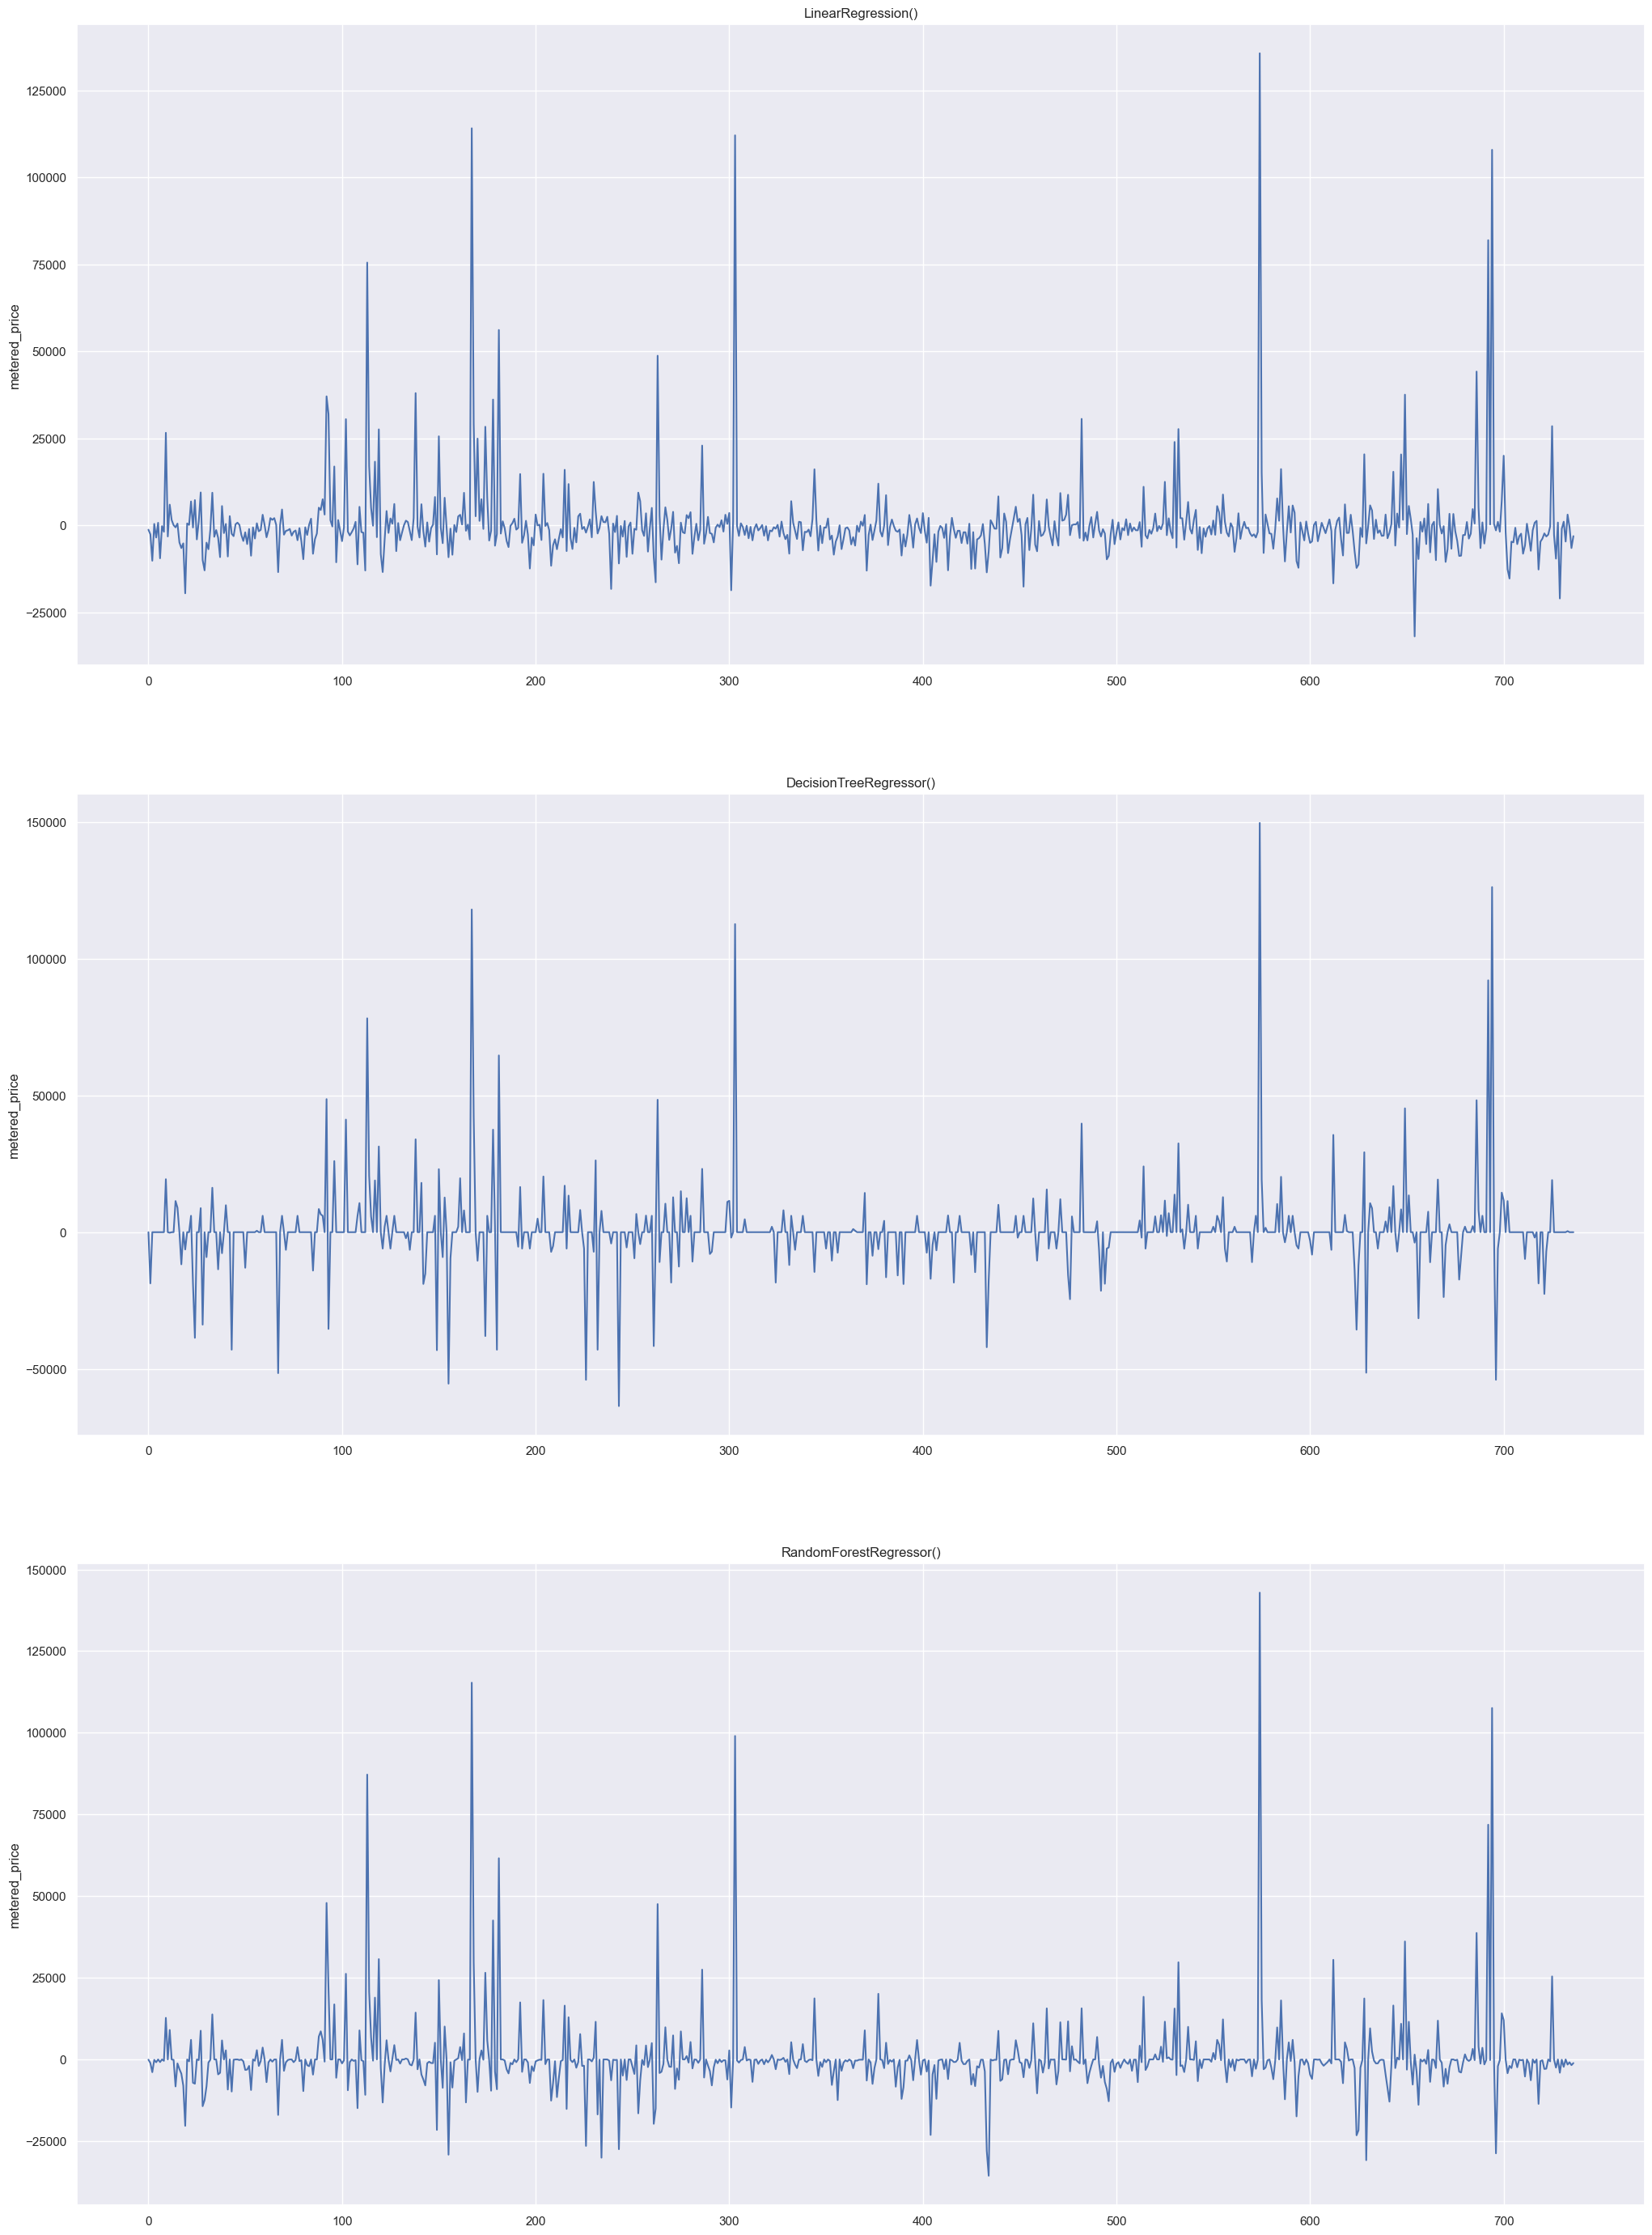

In [43]:
fig, axs = plt.subplots(nrows=3)
fig.set_figheight(35)
fig.set_figwidth(25)
AXIS = 0

for key, value in models.items():

    model = value
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    sns.lineplot(x = X_test.reset_index().index,
                 y = y_test - y_pred,
                 ax=axs[AXIS],
                 ).set(title=model
                       )

    print(f'Baseline MAE for {key} model:', round(mean_absolute_error(y_test, y_pred), 3),
          f'Baseline MSE for {key} model:', round(mean_squared_error(y_test, y_pred), 3),
          '\n'
          )
    error_list.append({'MAE_baseline': round(mean_absolute_error(y_test, y_pred), 3),
                       'MSE_baseline': round(mean_squared_error(y_test, y_pred), 3)
                       }
                      )
    AXIS += 1

We see that our models produce different errors, and the line chart visualizes these errors. Linear model mistakes for 5 465 units while counting the difference between actual `metered_price` and our basic `upfront_price`.
Similar results are witnessed for the other two models, but Random Forest performs relatively better.

<br>

### Baseline model, outliers in the data

The sample data has outliers, which could be observed on the pairplot above: all the dots-observations in the top right corner. I illustrate them once again via the boxplot below. These outliers do affect the performance of the linear model, at least.

In [44]:
df_cleaned

,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,prediction_price_type,predicted_distance,predicted_duration,driver_app_version,device_name,eu_indicator,hour,weekday
0,2020-02-02 03:37:31,4.04,10.0,2839,700,1,client,upfront,13384.0,1091.0,DA.4.37,Xiaomi Redmi 6,1,3,6
1,2020-02-08 02:26:19,6.09,3.6,5698,493,1,client,upfront,2286.0,360.0,DA.4.39,Samsung SM-G965F,1,2,5
2,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,upfront,4101.0,433.0,DA.4.37,Samsung SM-A530F,1,11,5
4,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,upfront,14236.0,2778.0,DA.4.37,Itel W5504,0,17,3
5,2020-02-14 01:27:01,6.11,6.3,4924,513,1,client,upfront,4882.0,562.0,DA.4.39,HUAWEI WAS-LX1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4936,2020-03-05 16:59:04,3.31,3.2,3343,471,1,client,upfront,3093.0,466.0,DA.4.42,Samsung SM-J510FN,1,16,3
4937,2020-03-05 07:42:25,7.01,5.6,10919,1465,1,client,upfront,9022.0,1029.0,DA.4.42,HUAWEI MAR-LX1A,1,7,3
4938,2020-03-07 17:42:34,10.89,13.7,15672,1449,1,client,upfront,16172.0,1691.0,DA.4.37,HUAWEI LYA-L29,1,17,5
4940,2020-03-12 23:08:31,7.50,7.4,5303,486,1,client,upfront,5141.0,498.0,DA.4.42,HUAWEI AMN-LX9,1,23,3


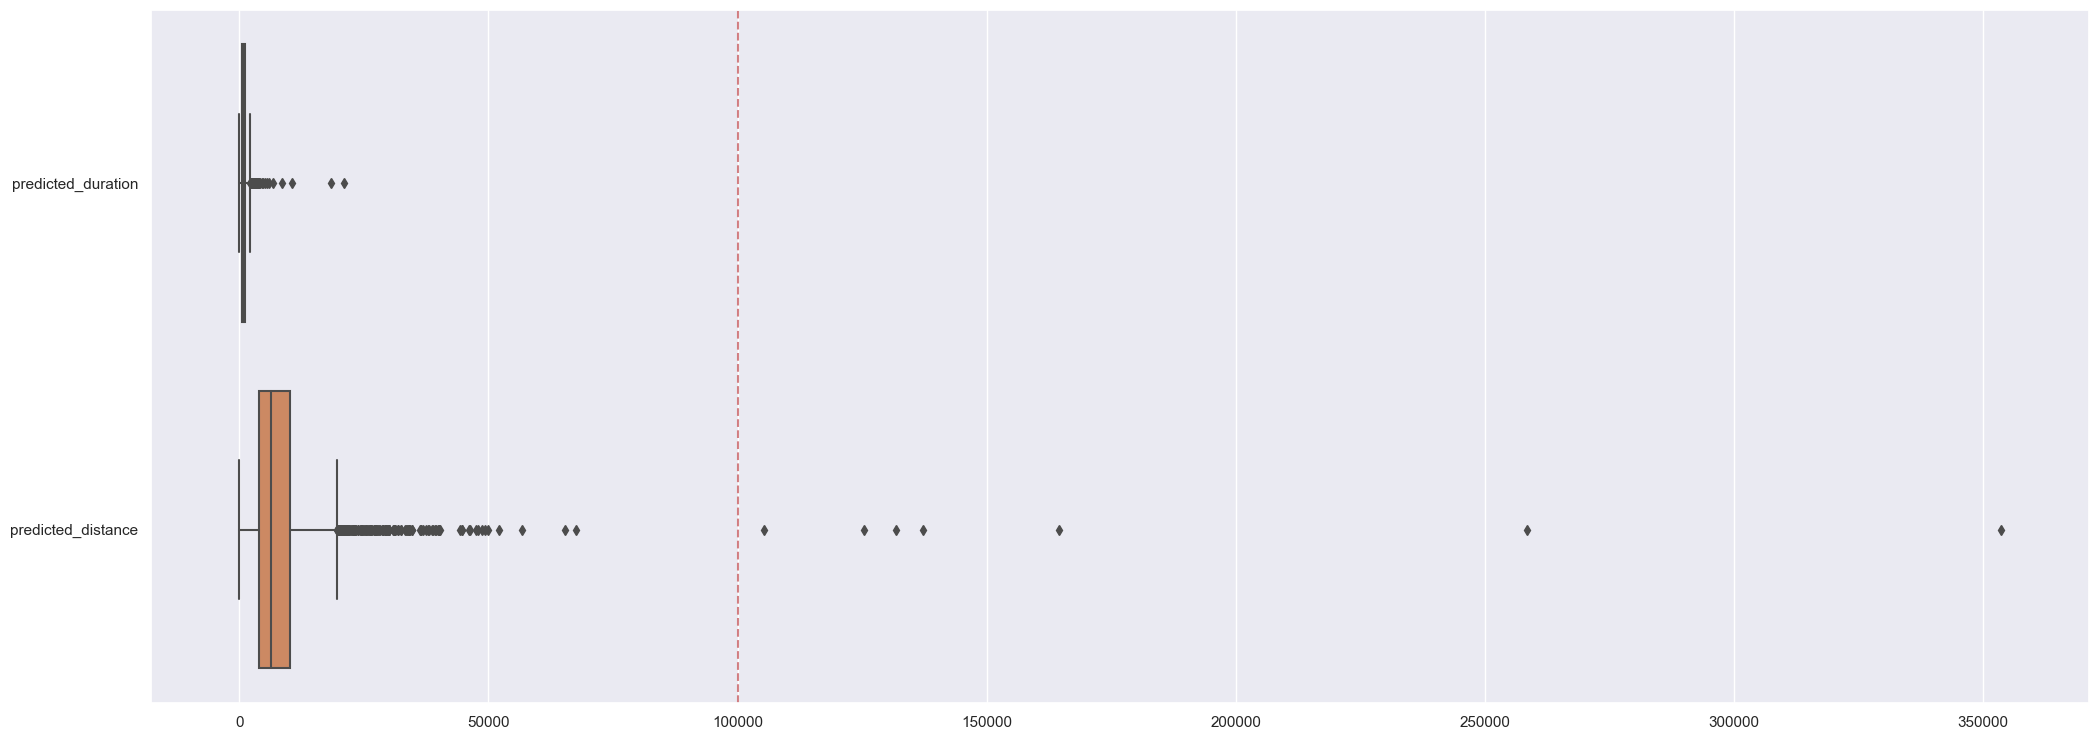

In [45]:
g=sns.boxplot(data=df_cleaned[['predicted_duration', 'predicted_distance']], orient='h')
g.axvline(100000,
          color='r',
          alpha=0.7,
          linestyle='dashed'
          )

Since it is just an example, I do not apply sophisticated techniques to address the outliers (IQR, Kernel density estimation); the threshold is made based on the boxplot.

In [46]:
df_outliers = df_cleaned.copy()
df_outliers = df_outliers[df_outliers['predicted_distance'] < 100000]

<AxesSubplot: >

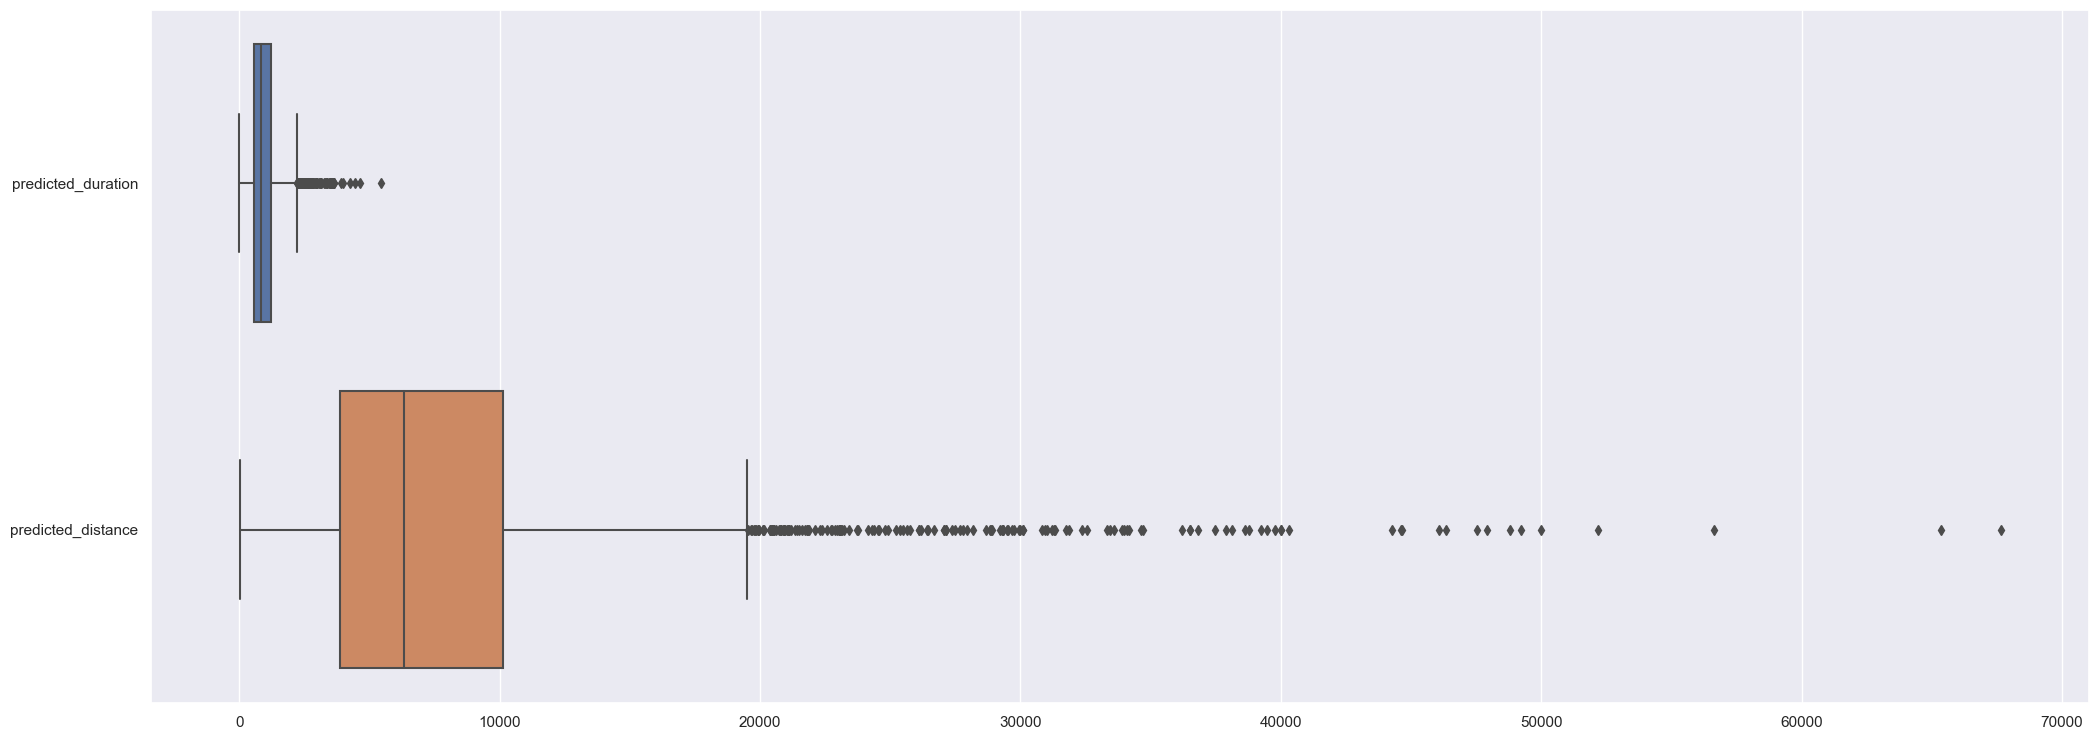

In [47]:
sns.boxplot(data=df_outliers[['predicted_duration', 'predicted_distance']],
            orient='h'
            )

In [48]:
X = df_outliers[['predicted_duration', 'predicted_distance']]
y = df_outliers['metered_price']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=904
                                                    )

models = {'Linear Regression': LinearRegression(),
          'Decision Tree': DecisionTreeRegressor(),
          'Random Forest': RandomForestRegressor()
          }

for key, value in models.items():
    model = value
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f'Baseline MAE for {key} model:', round(mean_absolute_error(y_test, y_pred), 3),
          f'Baseline MSE for {key} model:', round(mean_squared_error(y_test, y_pred), 3),
          '\n'
          )
    AXIS += 1

Baseline MAE for Linear Regression model: 5296.223 Baseline MSE for Linear Regression model: 137296415.149 

Baseline MAE for Decision Tree model: 5780.486 Baseline MSE for Decision Tree model: 234640554.719 

Baseline MAE for Random Forest model: 4904.501 Baseline MSE for Random Forest model: 156147734.625 



Compared to the baseline model, the model taught on the data without the outliers depicts better results, at least for the Linear model, as expected. So, this is my technical recommendation, which could also improve the quality of predictions for `upfront_price`.

However, there is a limitation connected to the long-distance services, which are, by default, outliers, so I would introduce the flag-indicator in the data to fix this. That is why in the following cells, I still use data with the outliers.

<br>

### Improving our baseline model

Now I will introduce selected variables in the training dataset to assess their effect!

In [49]:
features_list= {'hour_model': ['predicted_duration', 'predicted_distance', 'hour'],
                'weekday_model': ['predicted_duration', 'predicted_distance', 'weekday'],
                'gps_model': ['predicted_duration', 'predicted_distance', 'gps_confidence'],
                'hour_weekday_mode': ['predicted_duration', 'predicted_distance', 'hour', 'weekday'],
                'hour_weekday_eu_model': ['predicted_duration', 'predicted_distance', 'hour', 'weekday', 'eu_indicator']
                }

In [50]:
for model_name, features in features_list.items():
    error_list.append(' ')

    X = df_cleaned[features]
    y = df_cleaned['metered_price']

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        random_state=904
                                                        )
    print(f'____{model_name}____')
    for key, value in models.items():
        model = value
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f'MAE for {key} model:', round(mean_absolute_error(y_test, y_pred), 3),
              f'MSE for {key} model:', round(mean_squared_error(y_test, y_pred), 3), '\n')
        error_list.append({f'MAE_{model_name}': round(mean_absolute_error(y_test, y_pred), 3),
                           f'MSE_{model_name}': round(mean_squared_error(y_test, y_pred), 3)
                           }
                          )

____hour_model____
MAE for Linear Regression model: 5469.653 MSE for Linear Regression model: 153280143.555 

MAE for Decision Tree model: 5217.411 MSE for Decision Tree model: 215340045.943 

MAE for Random Forest model: 4598.446 MSE for Random Forest model: 147905120.657 

____weekday_model____
MAE for Linear Regression model: 5468.343 MSE for Linear Regression model: 151975468.848 

MAE for Decision Tree model: 5741.765 MSE for Decision Tree model: 299397336.59 

MAE for Random Forest model: 4933.192 MSE for Random Forest model: 155682217.729 

____gps_model____
MAE for Linear Regression model: 4931.819 MSE for Linear Regression model: 132213593.073 

MAE for Decision Tree model: 5426.381 MSE for Decision Tree model: 238674963.417 

MAE for Random Forest model: 4751.754 MSE for Random Forest model: 163513740.949 

____hour_weekday_mode____
MAE for Linear Regression model: 5498.364 MSE for Linear Regression model: 151811123.687 

MAE for Decision Tree model: 5585.473 MSE for Decision

In [51]:
error_list

[{'MAE_baseline': 5465.507, 'MSE_baseline': 153400198.608},
 {'MAE_baseline': 5560.246, 'MSE_baseline': 228187171.876},
 {'MAE_baseline': 4909.067, 'MSE_baseline': 158933087.901},
 ' ',
 {'MAE_hour_model': 5469.653, 'MSE_hour_model': 153280143.555},
 {'MAE_hour_model': 5217.411, 'MSE_hour_model': 215340045.943},
 {'MAE_hour_model': 4598.446, 'MSE_hour_model': 147905120.657},
 ' ',
 {'MAE_weekday_model': 5468.343, 'MSE_weekday_model': 151975468.848},
 {'MAE_weekday_model': 5741.765, 'MSE_weekday_model': 299397336.59},
 {'MAE_weekday_model': 4933.192, 'MSE_weekday_model': 155682217.729},
 ' ',
 {'MAE_gps_model': 4931.819, 'MSE_gps_model': 132213593.073},
 {'MAE_gps_model': 5426.381, 'MSE_gps_model': 238674963.417},
 {'MAE_gps_model': 4751.754, 'MSE_gps_model': 163513740.949},
 ' ',
 {'MAE_hour_weekday_mode': 5498.364, 'MSE_hour_weekday_mode': 151811123.687},
 {'MAE_hour_weekday_mode': 5585.473, 'MSE_hour_weekday_mode': 292669776.053},
 {'MAE_hour_weekday_mode': 4705.059, 'MSE_hour_weekda

As expected, our variables, either separately or jointly, positively impact the prediction power! However, not every sub-model benefits from the new variables: Linear model even shows worse results than the baseline for three out of four new models, yet, this is mostly a technical issue with the Linear model. On the brighter side, other Decision Trees and Random forests without parameter tuning do improve their predictions.

<br>

### Ultimate model

The last step is to include all variables in the data and check how it performs!

In [52]:
X = df_cleaned[['predicted_duration', 'predicted_distance', 'hour', 'weekday', 'eu_indicator', 'gps_confidence']]
y = df_cleaned['metered_price']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=904
                                                    )

Baseline MAE for Linear Regression model: 4254.391 Baseline MSE for Linear Regression model: 118374086.306 

Baseline MAE for Decision Tree model: 3436.037 Baseline MSE for Decision Tree model: 156874419.431 

Baseline MAE for Random Forest model: 2962.664 Baseline MSE for Random Forest model: 115066102.849 



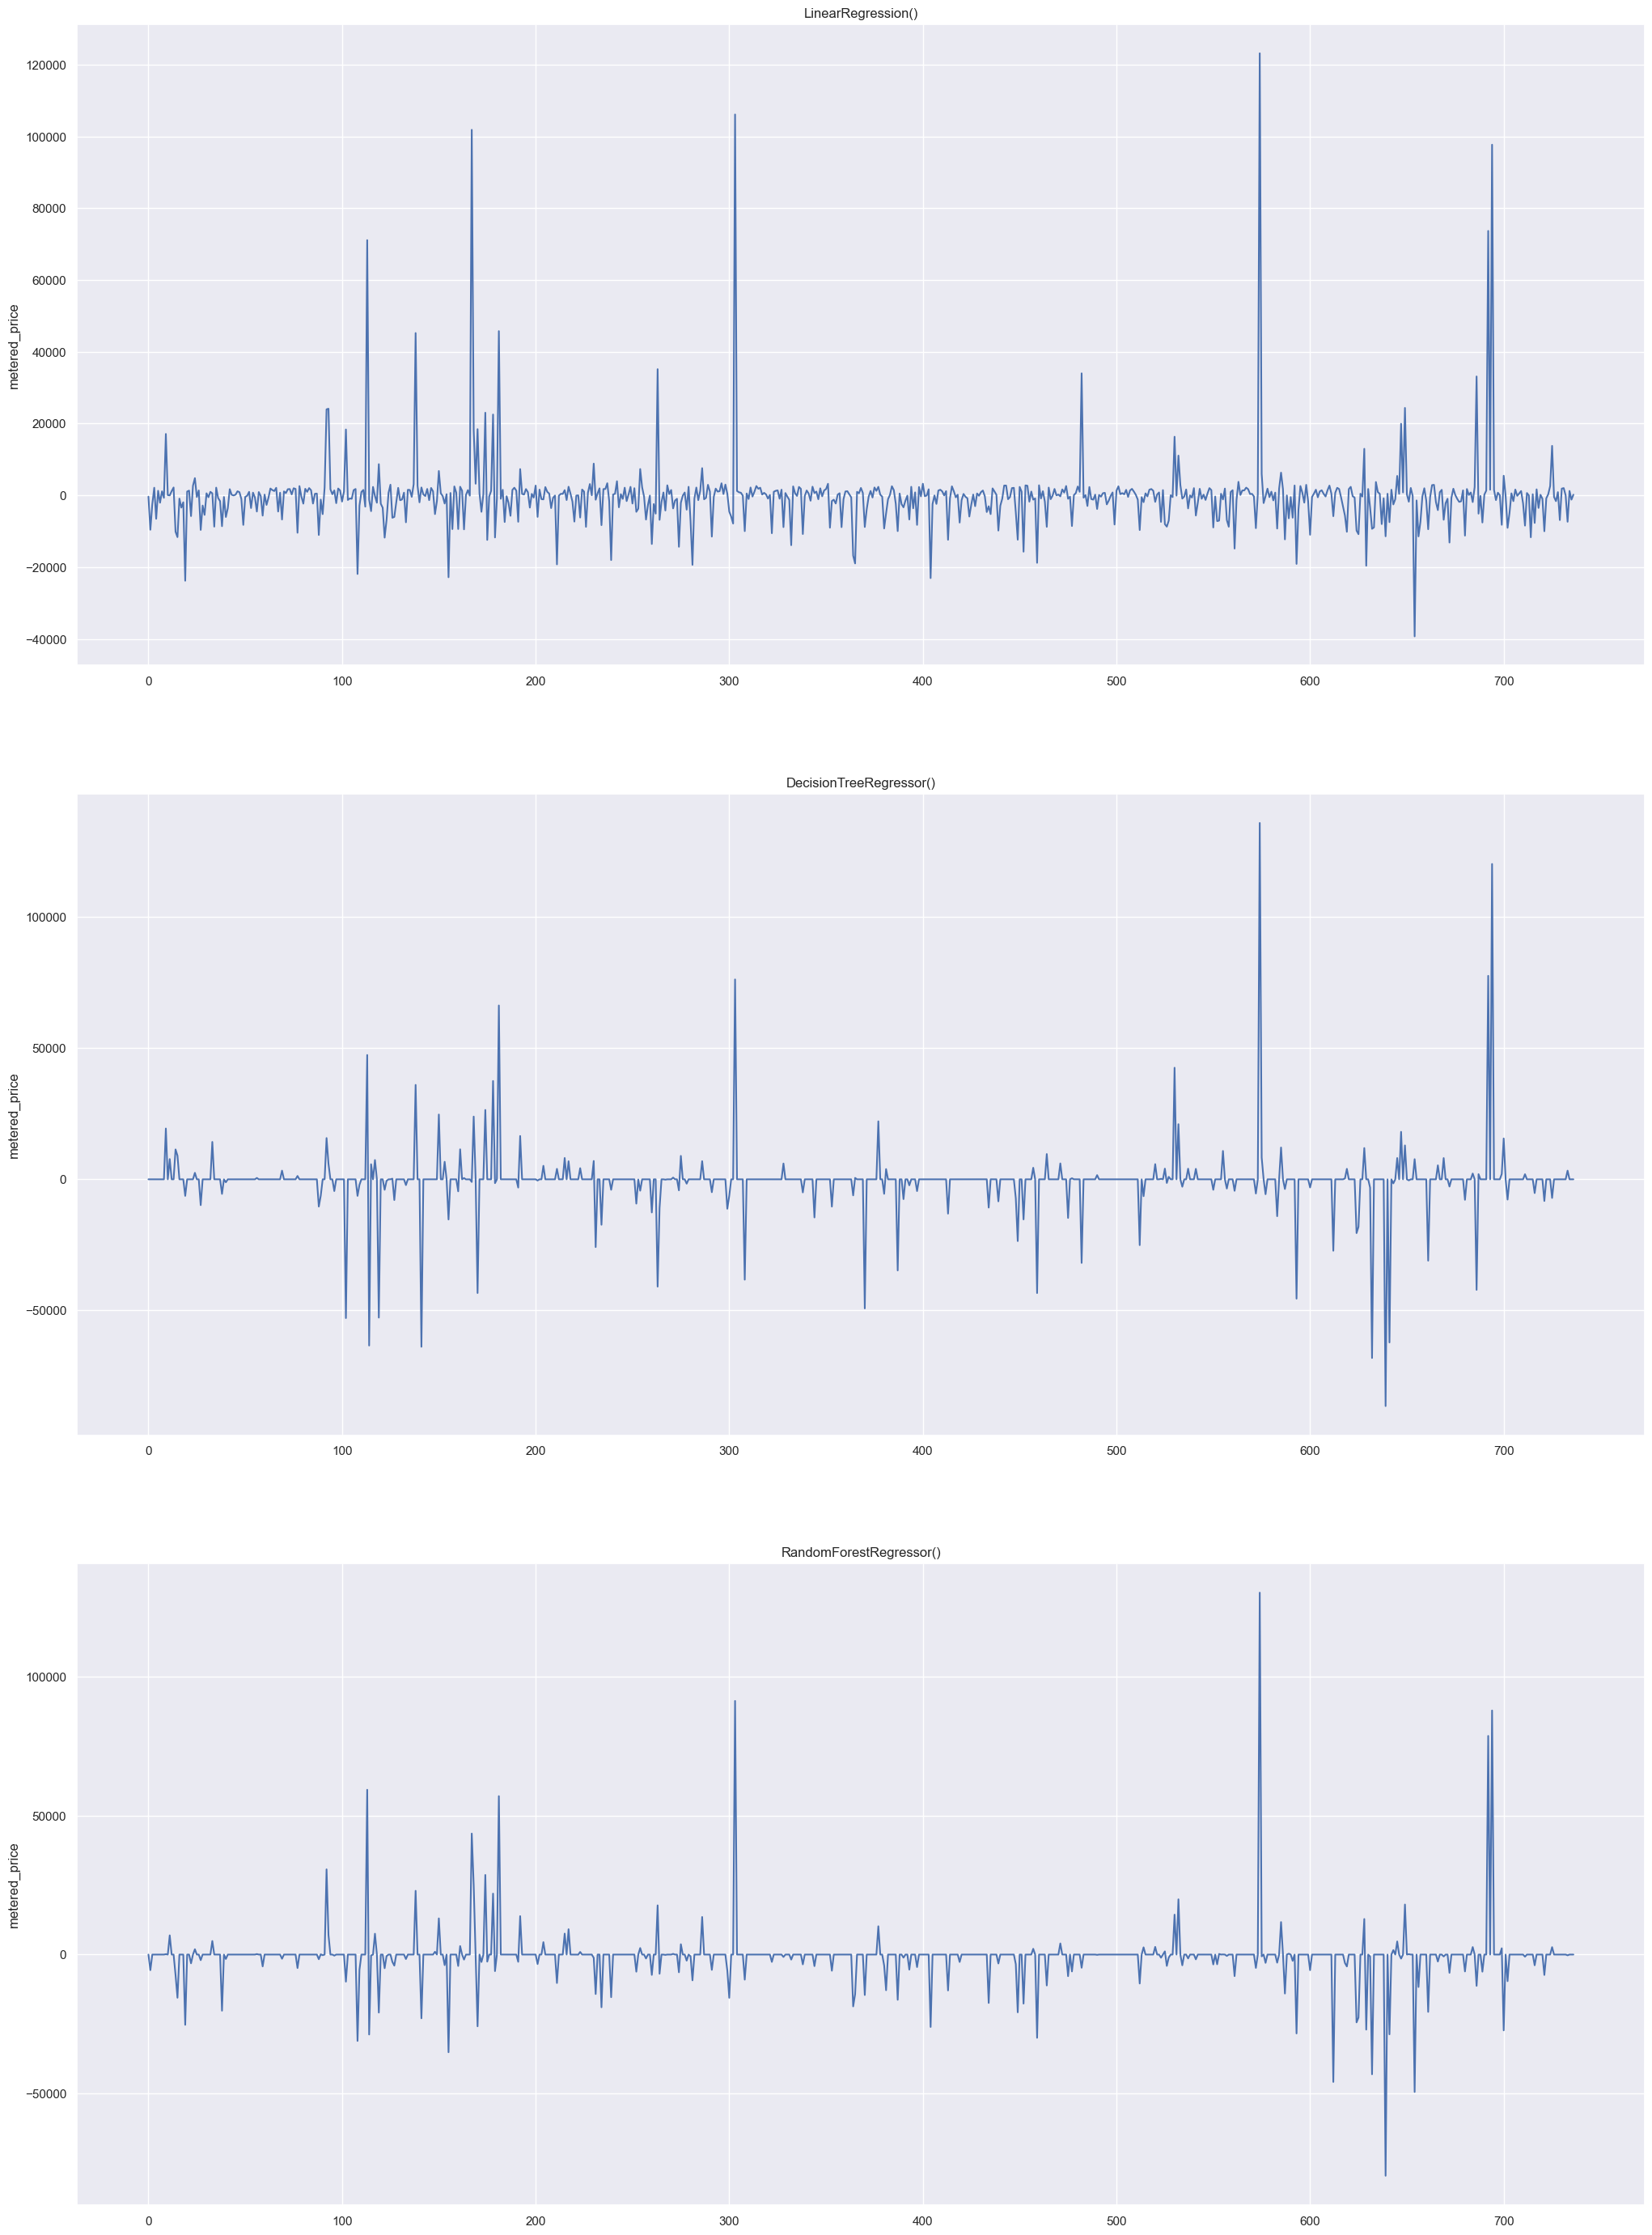

In [54]:
fig, axs = plt.subplots(nrows=3)
fig.set_figheight(35)
fig.set_figwidth(25)
AXIS = 0

for key, value in models.items():

    model = value
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    g=sns.lineplot(x = X_test.reset_index().index,
                 y = y_test - y_pred,
                 ax=axs[AXIS],
                 ).set(title=model
                       )

    print(f'Baseline MAE for {key} model:', round(mean_absolute_error(y_test, y_pred), 3),
          f'Baseline MSE for {key} model:', round(mean_squared_error(y_test, y_pred), 3),
          '\n'
          )
    error_list.append({'MAE_baseline': round(mean_absolute_error(y_test, y_pred), 3),
                       'MSE_baseline': round(mean_squared_error(y_test, y_pred), 3)
                       }
                      )
    AXIS += 1

Voila! Based on the Data analysis, I could improve the quality of predictions:
 - for the Linear model from 5465 to 4254 currency units;
 - for Decision Tree from 5572 to 3361 currency units;
 - for Random Forest from 4923 to 2863 currency units for both regions in the data.
These results are also supported visually: the number of spikes has decreased in comparison to the baseline model.

The values would be different if we change the random_state, yet the trend will be there nevertheless. This is the most vivid illustration that all previous discussions and analyses do make sense since they find support in the data!

The final conclusion is that there are more than two indicators, which can improve the quality of predictions, and which do improve the predictions by reducing the difference between `metered_price` and `upront_price`! Within this iteration of analysis, these variables are:
- Time when the order is made to control for the rush hours and, in theory, adjust the `predicted_duration` of a service
- Weekday when the order is made for the same purpose as above
- GPS connection which is tied to mobile phones and regional differences
- Speaking of regions, the EU and non-EU split has more effect than any other variables due to the complex nature of the indicator. Maybe there is a sense in providing two separate models for EU and non-EU markets; within this assignment, I could not do that because of the limited data.

For further analysis, I would do the following:
1. Get more information on the data
2. Additional feature engineering to create all necessary flags and code the `device_name` in a binary way
3. Tinker with the analysis a bit more to fully explain unpredicted `upfront_prices` and pinpoint additional associations
4. Introduce Pipeline to the Machine Learning process as well as cross-validation to ensure the robustness of the results